##Transformer로 번역기 만들기


개발 환경
<br/>데이터 정보


데이터 전처리
<br/>중복 제거
<br/>정제
<br/>토큰화

모델 구성
<br/>Transformer
<br/>Learning Rate Schedule
<br/>Loss Function
<br/>Train Step
<br/>Evaluation

모델 학습
<br/>최종 모델
<br/>모델 평가
<br/>Random State
<br/>결론
<br/>참고문헌

#개발 환경

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

한글 폰트를 설치한다.
<br/>혹시 깨짐현상이 발생하는 경우 런타임을 다시 시작하고 matplotlib 혹은 seaborn 모듈을 실행하면 한글이 출력된다.

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker

In [ ]:
font_list = [font.name for font in fm.fontManager.ttflist]
font_list

Google Colab에 한글 폰트가 설치되어 있는지 확인한다.

In [ ]:
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

Attention Map을 확인하기 위해 한국어를 지원하는 폰트로 변경한다.

In [ ]:
!pip install sentencepiece

In [ ]:
import os
import io
import time
import random
import warnings
warnings.filterwarnings(action='ignore')
from tqdm.notebook import tqdm 
from IPython.display import HTML
from IPython.display import Image

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn 

In [ ]:
import re
import sentencepiece as spm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip freeze > '/content/drive/MyDrive/lms/library_version.txt'

In [ ]:
library_name = ['matplotlib=', 'tqdm=', 'tensorflow=', 'pandas=', 'numpy=', 
                'seaborn=', 'regex=', 'sentencepiece=']
library_version = []
f = open('/content/drive/MyDrive/lms/library_version.txt', 'r')
line = f.readline()
while True:
    line = f.readline()
    if not line:
      break
    for i in library_name:
      if i in line:
        library_version.append(line)
        library_version.append('    ')

f.close()

import sys
print(sys.version)
print()

for i in range(0, len(library_version) - 1, 6):
  print(str(library_version[i : i+6]).replace("[","").replace("]","").replace("'","").replace("\\n","").replace(",",""), end='') 
  if i % 6 == 0:
    print()

for i in range(len(library_version) - 1):
  if (i-1) % 6 == 0 and i == len(library_version) - 6:
    print(str(library_version[-1]).replace("[","").replace("]","").replace("'","").replace("\\n","").replace(",",""), end='')

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

matplotlib==3.2.2      numpy==1.21.6      pandas==1.3.5     
regex==2022.6.2      seaborn==0.11.2      sentencepiece==0.1.96     
sklearn-pandas==1.8.0      tensorflow==2.8.2+zzzcolab20220719082949      tqdm==4.64.0     


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Google Colab에서 할당된 GPU를 확인한다.
<br/>고용량 메모리 VM에 액세스한다

#데이터 정보

[Korean Parallel Corpora](https://github.com/jungyeul/korean-parallel-corpora)

한국어의 형태소 분석과 품사 태깅, 기계 번역 연구를 위해 공개된 데이터이다.

[Korean English News V1](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

한국어-영어 병렬 코퍼스 데이터이다.

In [ ]:
path_to_kor = '/content/drive/MyDrive/lms/transformer_translation/korean_parallel_corpora/korean-english-park.train.ko'

with open(path_to_kor, "r") as f:
    ko_raw = f.read().splitlines()

print("Data Size :", len(ko_raw))
print()
print("Example")
for kor_sen in ko_raw[600:700][::20]: print("", kor_sen)

Data Size : 94123

Example
 앞서가고 있는 은행 중의 하나가 오하이오 주 콜럼버스에 있는 헌팅턴 뱅크쉐어즈이다.
 우리 내부의 신체 시계는 밤 에 자고, 낮 에 사냥하는 그러한 세계에 최적의 상태로 적응되어 있습니다."
 하지만 얼마나 오래 그 효과가 지속될 것인가?
 그 이름이 뜻하는 바와 같이 이 세균은 이미 밴코마이신과 모든 다른 항생물질에 대해 면역성을 갖게 되었다.
 하나의 통신망은 모뎀이나 케이블에 의해 호스트 컴퓨터나 서버에 접속되어 있는 일단의 컴퓨터들을 말한다.


In [ ]:
path_to_eng = '/content/drive/MyDrive/lms/transformer_translation/korean_parallel_corpora/korean-english-park.train.en'

with open(path_to_eng, "r") as f:
    en_raw = f.read().splitlines()

print("Data Size :", len(en_raw))
print()
print("Example")
for eng_sen in en_raw[600:700][::20]: print("", eng_sen)

Data Size : 94123

Example
 A leader is Huntington Bankshares in Columbus, Ohio.
 Our internal clocks adapted us perfectly to a world where we slept by night and hunted by day."
 But how long will it hold up?
 As the name implies, it's already become immune to Vancomycin and every other antibiotic.
 A network is a group of computers joined to a host computer or server by modems or by cables.


#데이터 전처리

##중복 제거

In [ ]:
ko_raw_dict = {string : i for i,string in enumerate(ko_raw)}
en_raw_dict = {string : i for i,string in enumerate(en_raw)}

딕셔너리를 생성하면서 중복되는 key 값을 제외한다.
<br/>자료구조 딕셔너리는 중복되는 key 값을 허용하지 않는다.

In [ ]:
ko_raw_df = pd.DataFrame(list(ko_raw_dict.items()), columns=['key', 'value'])
en_raw_df = pd.DataFrame(list(en_raw_dict.items()), columns=['key', 'value'])
df_INNER_JOIN = pd.merge(ko_raw_df, en_raw_df, left_on='value', right_on='value', how='inner')

In [ ]:
df_INNER_JOIN

,key_x,value,key_y
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""",0,"Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,1,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,2,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",3,uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,4,Intelligence officials have revealed a spate o...
...,...,...,...
74449,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,94118,””We are hoping to seize material evidence to ...
74450,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,94119,"” On Monday, police secured statements from si..."
74451,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,94120,But the lack of material evidence is making it...
74452,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,94121,Kim and his son both deny the allegations.


데이터의 병렬 쌍이 흐트러지지 않도록 데이터프레임의 INNER JOIN을 한다.

In [ ]:
ko_unique = list(df_INNER_JOIN['key_x'])
en_unique = list(df_INNER_JOIN['key_y'])

데이터프레임의 key_x, key_y를 리스트로 저장한다.
<br/>kor_unique는 중복 데이터를 제외한 한국어 문장의 리스트이다.
<br/>eng_unique는 중복 데이터를 제외한 영어 문장의 리스트이다.

##정제

In [ ]:
def preprocess_sentence(sentence):

    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence

In [ ]:
ko_corpus = []
en_corpus = []

for ko_sen in ko_unique[:]:
  ko_corpus.append(preprocess_sentence(ko_sen))

for en_sen in en_unique[:]:
  en_corpus.append(preprocess_sentence(en_sen))

In [ ]:
print("Korean \n", ko_corpus[90])  
print()
print("English \n", en_corpus[90])  

Korean 
 그는 이 연구 결과가 심장 협회의 지침과도 부합된다고 말했는데 , 심장 협회의 지침은 일주일에 적어도 일은 유산소 운동을 하고 , 매주 번은 근력 운동을 하라고 권장하고 있다 .

English 
 he said the findings correspond with aha guidelines , which recommend aerobic exercise at least six days a week and weight training two or three times weekly .


##단어 사전

In [ ]:
temp_file = '/content/drive/MyDrive/lms/transformer_translation/korean_parallel_corpora/korean-english-park.train.ko.temp'

vocab_size = 20000

with open(temp_file, 'w') as f:
    for row in ko_corpus:   
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)

!ls -l korean_spm*

-rw-r--r-- 1 root root 623710 Jul 22 16:48 korean_spm.model
-rw-r--r-- 1 root root 404078 Jul 22 16:48 korean_spm.vocab


In [ ]:
temp_file = '/content/drive/MyDrive/lms/transformer_translation/korean_parallel_corpora/korean-english-park.train.en.temp'

vocab_size = 20000

with open(temp_file, 'w') as f:
    for row in en_corpus:   
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=english_spm --vocab_size={}'.format(temp_file, vocab_size)    
)

!ls -l english_spm*

-rw-r--r-- 1 root root 575204 Jul 22 16:48 english_spm.model
-rw-r--r-- 1 root root 355453 Jul 22 16:48 english_spm.vocab


##토큰화

한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후 정제하여 토큰화를 진행한다.
<br/>토큰화에는 Sentencepiece를 활용한다.
<br/>첨부된 공식 사이트를 참고해 아래 조건을 만족하는 generate_tokenizer() 함수를 정의한다.
<br/>최종적으로 ko_tokenizer 과 en_tokenizer 를 얻는다.
<br/>en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 한다.

단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 한다. (기본: 20,000)
<br/>학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환한다.
<br/>특수 토큰의 인덱스를 아래와 동일하게 지정한다.
<br/>< PAD > : 0 / < BOS > : 1 / < EOS > : 2 / < UNK > : 3

In [ ]:
def generate_tokenizer(corpus,
                        vocab_size,
                        lang,
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    
    data_path = '/content/drive/MyDrive/lms/transformer_translation/korean_parallel_corpora'
    model_path = '/content/drive/MyDrive/lms/transformer_translation/model'

    corpus_path = f'{data_path}/sp_train_corpus_{lang}.temp'
    with open(corpus_path, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')

    prefix = f'{model_path}/spm_{lang}'
    
    spm.SentencePieceTrainer.Train(
        f'--input={corpus_path} \
            --model_prefix={prefix} \
            --vocab_size={vocab_size} \
            --model_type=unigram \
            --pad_id={pad_id} \
            --bos_id={bos_id} \
            --eos_id={eos_id} \
            --unk_id={unk_id}')
    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'{prefix}.model')

    return tokenizer

In [ ]:
src_vocab_size = tgt_vocab_size = 20000

ko_tokenizer = generate_tokenizer(ko_corpus, src_vocab_size, "ko")
en_tokenizer = generate_tokenizer(en_corpus, tgt_vocab_size, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

In [ ]:
src_corpus = []
tgt_corpus = []
text_max_len = 50

assert len(ko_corpus) == len(en_corpus)

for idx in tqdm(range(len(ko_corpus))):
    ko_tokenized = ko_tokenizer.EncodeAsIds(ko_corpus[idx])
    en_tokenized = en_tokenizer.EncodeAsIds(en_corpus[idx])
    
    if len(ko_tokenized) <= text_max_len and len(en_tokenized) <= text_max_len:
        src_corpus.append(ko_tokenized)
        tgt_corpus.append(en_tokenized)

enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/74454 [00:00<?, ?it/s]

In [ ]:
print("Korean Encoded")
print(enc_train[1], "\n")
print("Korean Decoded")
print(ko_tokenizer.DecodeIds(enc_train[1].tolist()), "\n\n")
print("English Encoded")
print(dec_train[1], "\n")
print("English Decoded")
print(en_tokenizer.DecodeIds(dec_train[1].tolist()), "\n")

Korean Encoded
[  171  3549   382  3623    27  3436   182    19  3549   382  3623    28
 11105  1834  1254     6 15668  1427   160    10  5293   421   447     4
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0] 

Korean Decoded
모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다 . 


English Encoded
[    1   144     8  2748     8   407   553   352    56     8  9591   239
  3815 11631  5581    40   201  1239    12    31   235  9591   239     6
  3815  5581    40     5     2     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0] 

English Decoded
so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable , wireless mouse . 



#모델 구성

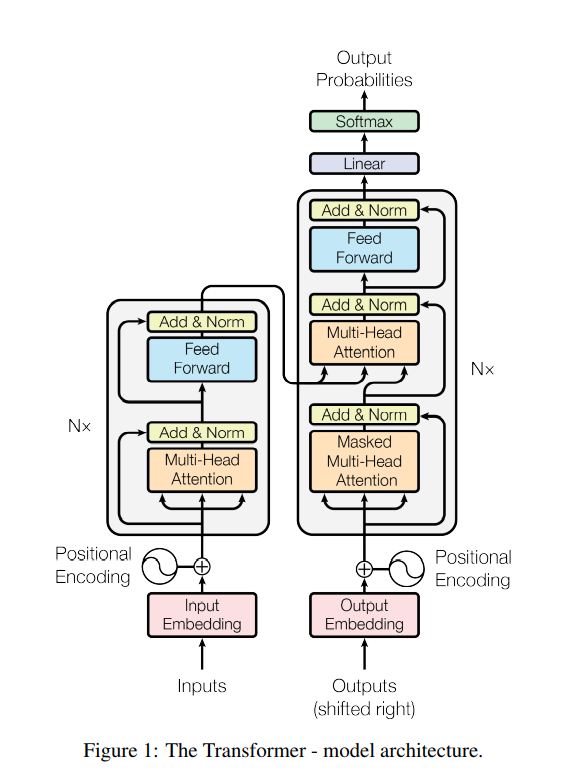

In [ ]:
Image(filename='/content/drive/MyDrive/lms/transformer_translation/Transformer.png') 

##Transformer

In [ ]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        matmul_qk = tf.matmul(Q, K, transpose_b=True)
        dk = tf.cast(K.shape[-1], tf.float32)
        scaled_qk = matmul_qk / tf.math.sqrt(dk)
        
        # print('scaled_dot_product_attention')
        # print(f'Q.shape : {Q.shape}')
        # print(f'K.shape : {K.shape}')
        # print(f'V.shape : {V.shape}')
        # print(f'mask.shape : {mask.shape}')
        # print(f'scaled_qk.shape : {scaled_qk.shape}')
        if mask is not None: 
            scaled_qk += (mask * -1e9)

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        # print(f'attentions.shape : {attentions.shape}')
        out = tf.matmul(attentions, V)
        # print(f'out.shape : {out.shape}\n')

        return out, attentions
        

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x
    

    def call(self, Q, K, V, mask):
        """
        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

In [ ]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [ ]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

In [ ]:
def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

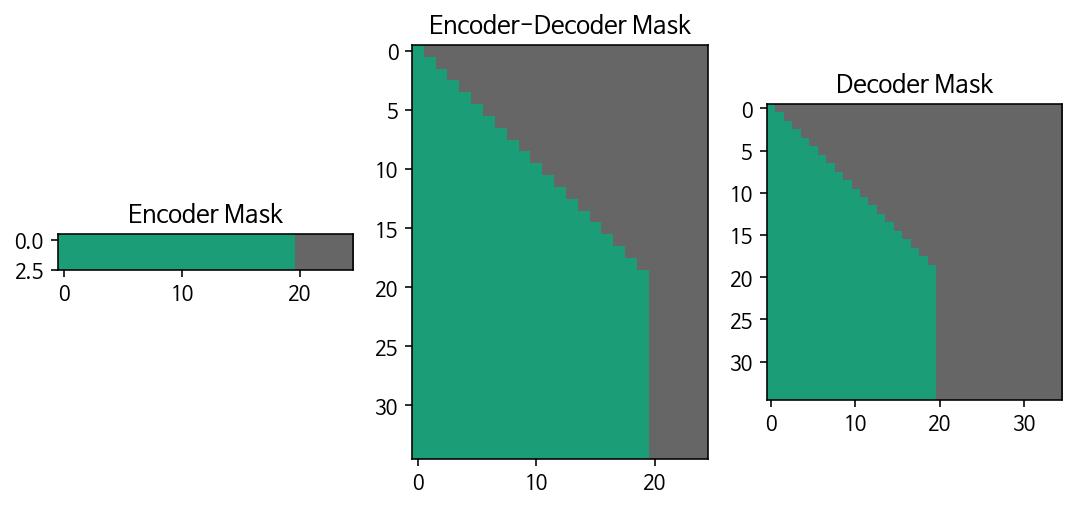

In [ ]:
batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(9, 9))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('Encoder Mask')
ax2.set_title('Encoder-Decoder Mask')
ax3.set_title('Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

##Learning Rate Schedule 

In [ ]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

##Loss Function

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

##Train Step

In [ ]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

##Evaluation

In [ ]:
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(16, 8))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        print()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(16, 8))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()
        print()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(16, 8))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()
        print()

In [ ]:
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [ ]:
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=True):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    print()

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [ ]:
def sentence_translator(sentence, model, src_tokenizer, tgt_tokenizer):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

#모델 학습

In [ ]:
transformer = Transformer(n_layers=2, 
                          d_model=512, 
                          n_heads=8, 
                          d_ff=2048, 
                          src_vocab_size=src_vocab_size, 
                          tgt_vocab_size=tgt_vocab_size, 
                          pos_len=256, 
                          dropout=0.1)

In [ ]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [ ]:
model_loss_df = pd.DataFrame({'Epoch':[0],
                             'Train Loss':[0]})

batch_size = 64
epochs = 30
train_count = 0

sentence_list = ["오바마는 대통령이다.", "시민들은 도시 속에 산다.",
                 "커피는 필요 없다.", "일곱 명의 사망자가 발생했다."]

for epoch in range(epochs):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], batch_size))
    random.shuffle(idx_list)

    for (batch, idx) in enumerate(idx_list):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+batch_size],
                    dec_train[idx:idx+batch_size],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        train_count += 1

        if train_count % len(idx_list) == 0:
            model_loss_df.loc[epoch] = [epoch + 1, round(total_loss.numpy() / (batch + 1), 4)]
            model_loss_df = model_loss_df.astype({'Epoch':'int'})
        
            if epoch == 0 or (epoch + 1) % 2 == 0:
                print('Epoch {}'.format(epoch + 1))
                print('Train Loss {:.4f}'.format(total_loss.numpy() / (batch + 1)))
                print()

                for sentence in sentence_list:
                    sentence_translator(sentence, transformer, ko_tokenizer, en_tokenizer)
                    print()
                print()

Epoch 1
Train Loss 6.0602

Input: 오바마는 대통령이다.
Predicted translation: obama is obama s obama .

Input: 시민들은 도시 속에 산다.
Predicted translation: the year old boys were killed .

Input: 커피는 필요 없다.
Predicted translation: the reason is not to be .

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the two hours were killed .


Epoch 2
Train Loss 4.5847

Input: 오바마는 대통령이다.
Predicted translation: obama is a little bit of the president .

Input: 시민들은 도시 속에 산다.
Predicted translation: the city s urban is away .

Input: 커피는 필요 없다.
Predicted translation: coffee is not no matter .

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the total , , died sunday .


Epoch 4
Train Loss 3.5875

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .

Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the city s .

Input: 커피는 필요 없다.
Predicted translation: it needs to need .

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the death toll .


Epoch 6
Train Loss 2.4921

Input: 오바마는 대통령

In [ ]:
pd.set_option('display.max_rows', 10)
model_loss_df

,Epoch,Train Loss
0,1,6.0602
1,2,4.5847
2,3,3.9839
3,4,3.5875
4,5,3.0987
...,...,...
25,26,0.1257
26,27,0.1215
27,28,0.1154
28,29,0.1109


In [ ]:
model_loss_df.to_csv("/content/drive/MyDrive/lms/transformer_translation/model_loss.csv", index = False)

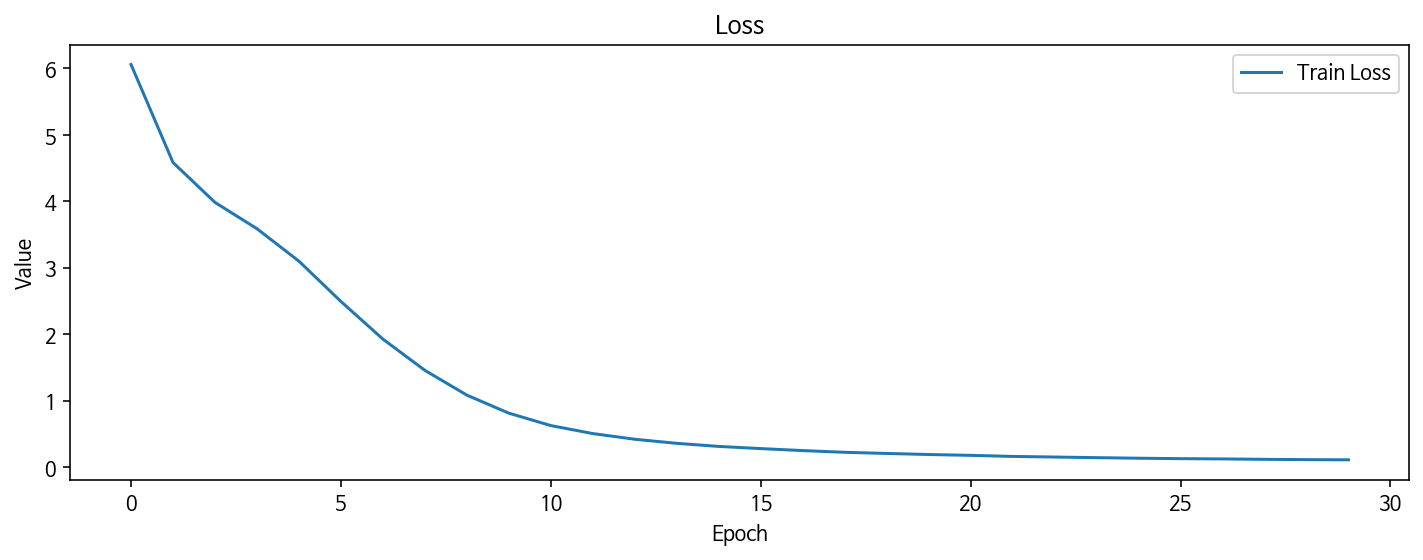

In [ ]:
plt.figure(figsize=[12, 4])
plt.plot(model_loss_df['Train Loss'] , label="Train Loss")
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()

최종 모델의 Epoch을 10으로 설정한다.
<br/>Epoch 10 이상부터는 Train Loss의 변화가 거의 없고 Test Loss가 증가하여 과적합 문제가 심해진다.

#최종 모델

In [ ]:
transformer = Transformer(n_layers=2, 
                          d_model=512, 
                          n_heads=8, 
                          d_ff=2048, 
                          src_vocab_size=src_vocab_size, 
                          tgt_vocab_size=tgt_vocab_size, 
                          pos_len=256, 
                          dropout=0.1)

In [ ]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [ ]:
final_model_loss_df = pd.DataFrame({'Epoch':[0],
                             'Train Loss':[0]})

batch_size = 64
epochs = 10
train_count = 0

for epoch in range(epochs):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], batch_size))
    random.shuffle(idx_list)

    for (batch, idx) in enumerate(idx_list):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+batch_size],
                    dec_train[idx:idx+batch_size],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        train_count += 1

        if train_count % len(idx_list) == 0:
            final_model_loss_df.loc[epoch] = [epoch + 1, round(total_loss.numpy() / (batch + 1), 4)]
            final_model_loss_df = final_model_loss_df.astype({'Epoch':'int'})
            print('Epoch {}  Train Loss {:.4f}'.format(epoch + 1, total_loss.numpy() / (batch + 1)))

Epoch 1  Train Loss 6.0585
Epoch 2  Train Loss 4.5797
Epoch 3  Train Loss 3.9776
Epoch 4  Train Loss 3.5826
Epoch 5  Train Loss 3.0897
Epoch 6  Train Loss 2.4725
Epoch 7  Train Loss 1.9086
Epoch 8  Train Loss 1.4308
Epoch 9  Train Loss 1.0601
Epoch 10  Train Loss 0.7867


In [ ]:
final_model_loss_df

,Epoch,Train Loss
0,1,6.0585
1,2,4.5797
2,3,3.9776
3,4,3.5826
4,5,3.0897
5,6,2.4725
6,7,1.9086
7,8,1.4308
8,9,1.0601
9,10,0.7867


In [ ]:
final_model_loss_df.to_csv("/content/drive/MyDrive/lms/transformer_translation/final_model_loss.csv", index = False)

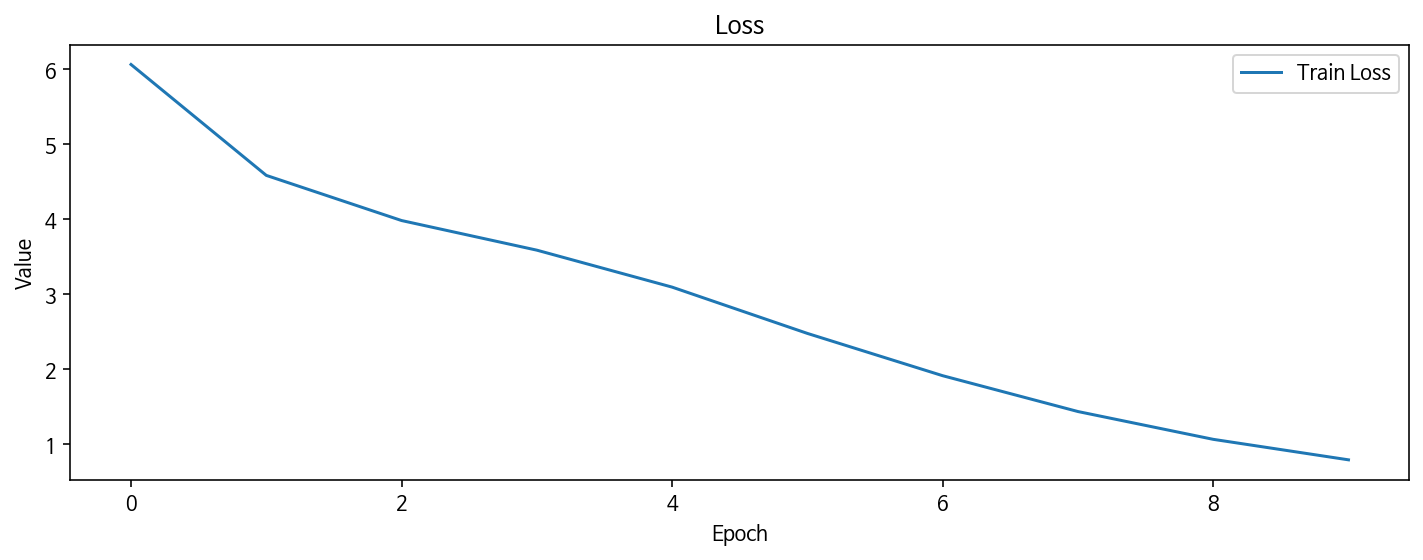

In [ ]:
plt.figure(figsize=[12, 4])
plt.plot(final_model_loss_df['Train Loss'] , label="Train Loss")
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()

#모델 평가

In [ ]:
sentence_list = ["오바마는 대통령이다.", "시민들은 도시 속에 산다.",
                 "커피는 필요 없다.", "일곱 명의 사망자가 발생했다."]

for sentence in sentence_list:
                    sentence_translator(sentence, transformer, ko_tokenizer, en_tokenizer)
                    print()

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .

Input: 시민들은 도시 속에 산다.
Predicted translation: the city puts around the world .

Input: 커피는 필요 없다.
Predicted translation: no need to no . . . . no need .

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven people were killed and seven others were hurt .



Input: 오바마는 대통령이다.
Predicted translation: obama is the president .

Encoder Layer 1


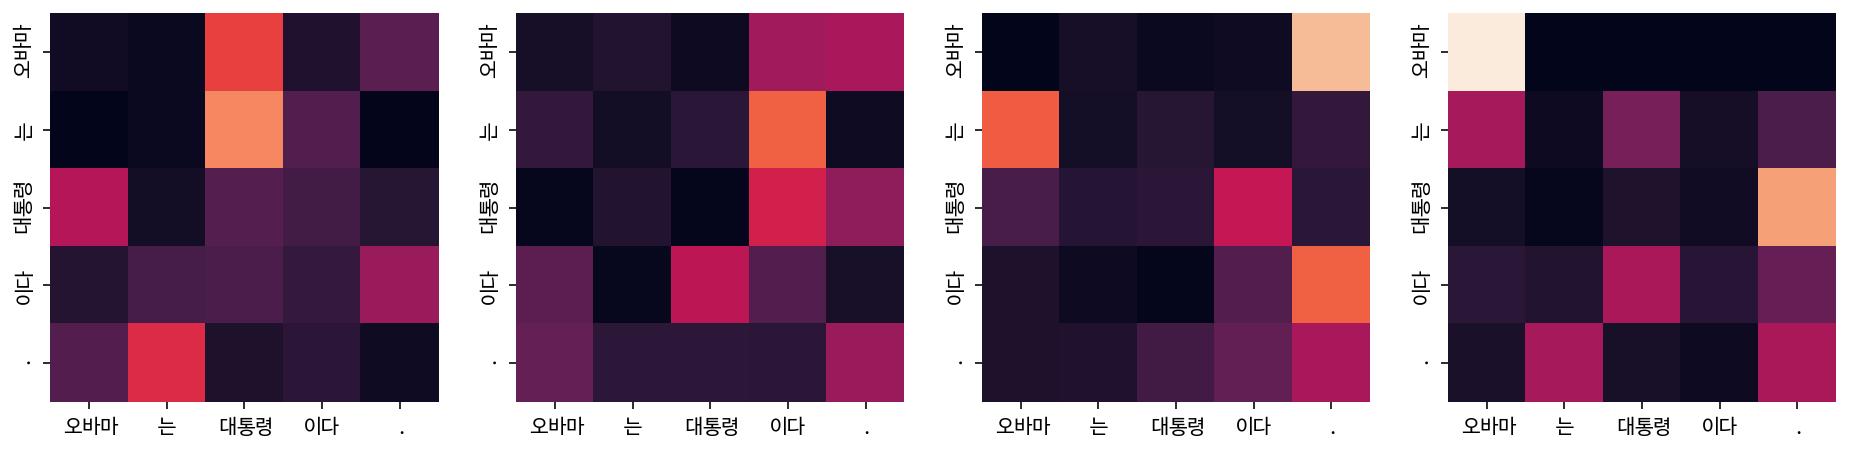


Encoder Layer 2


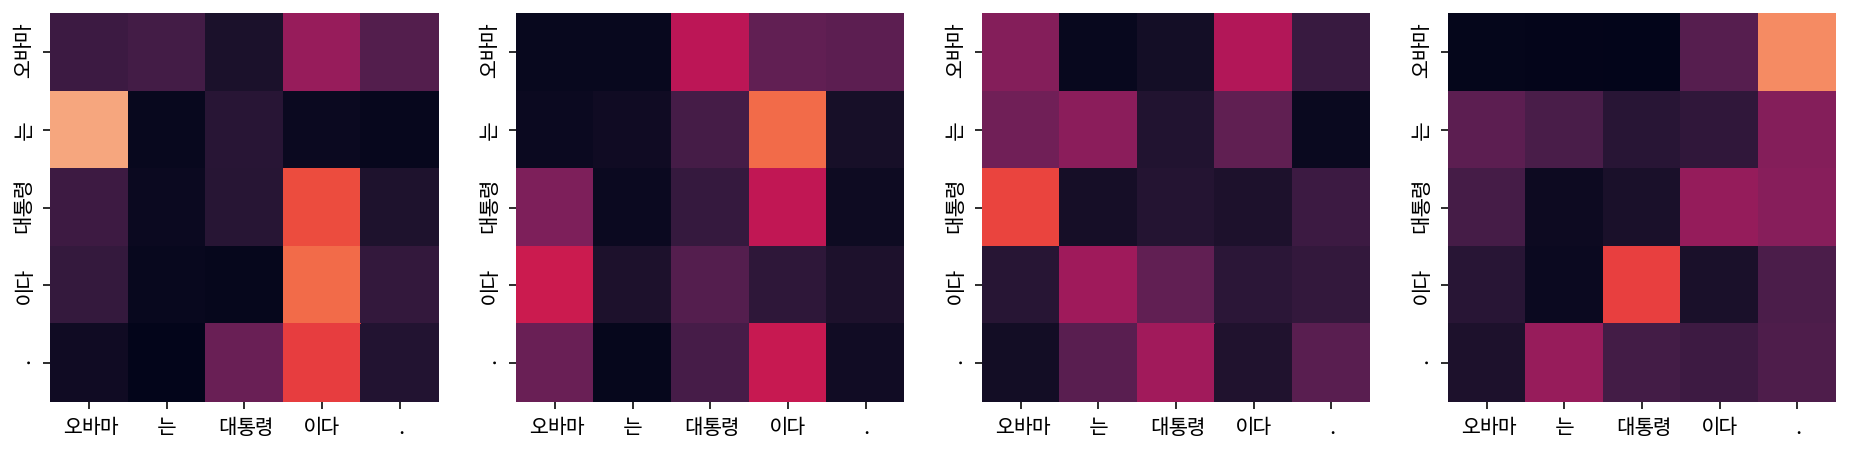


Decoder Self Layer 1


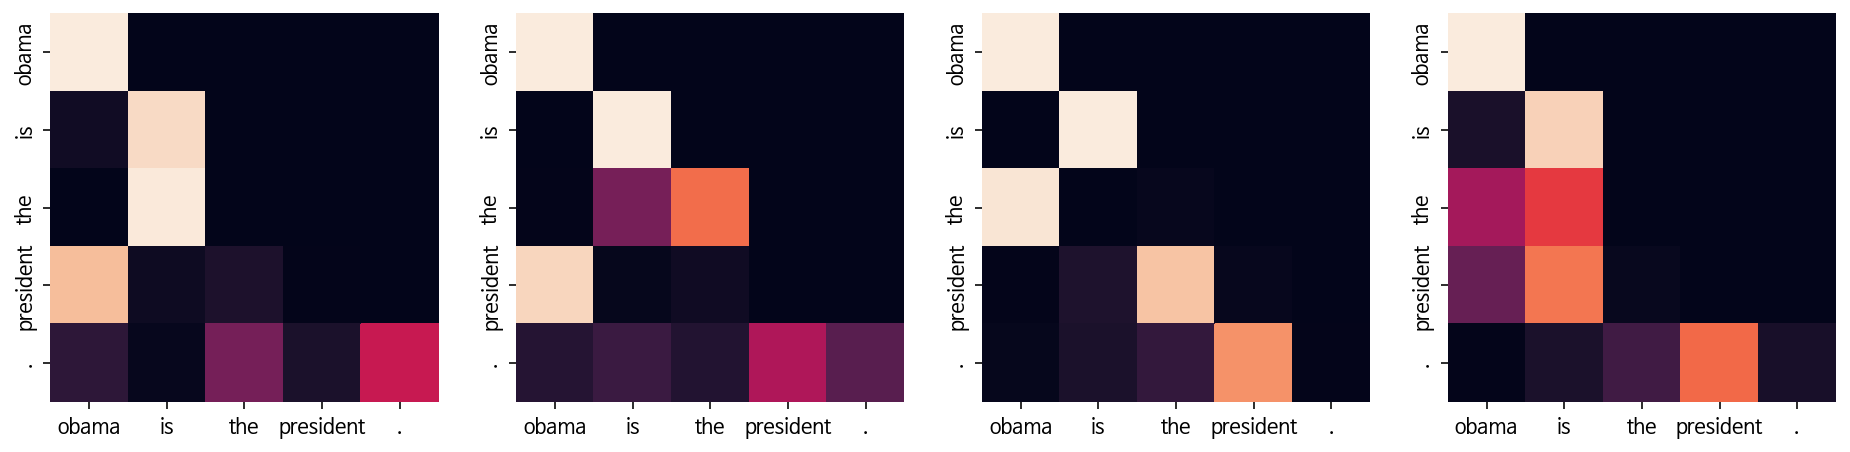


Decoder Src Layer 1


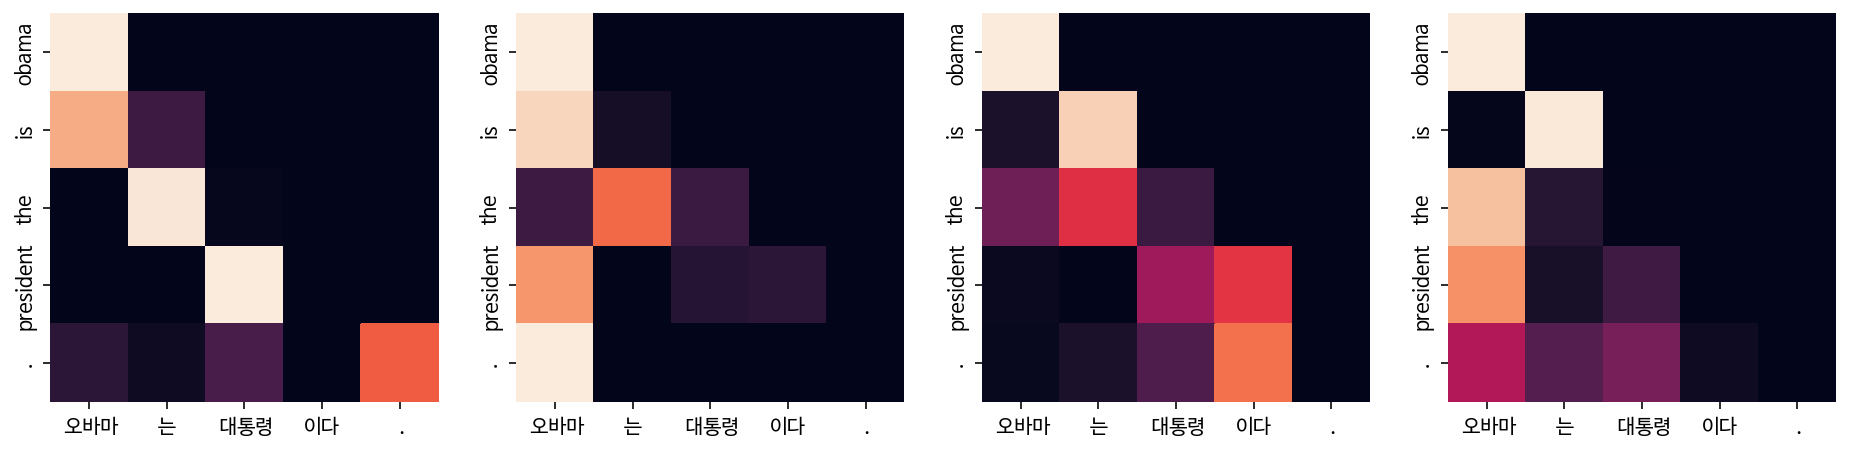


Decoder Self Layer 2


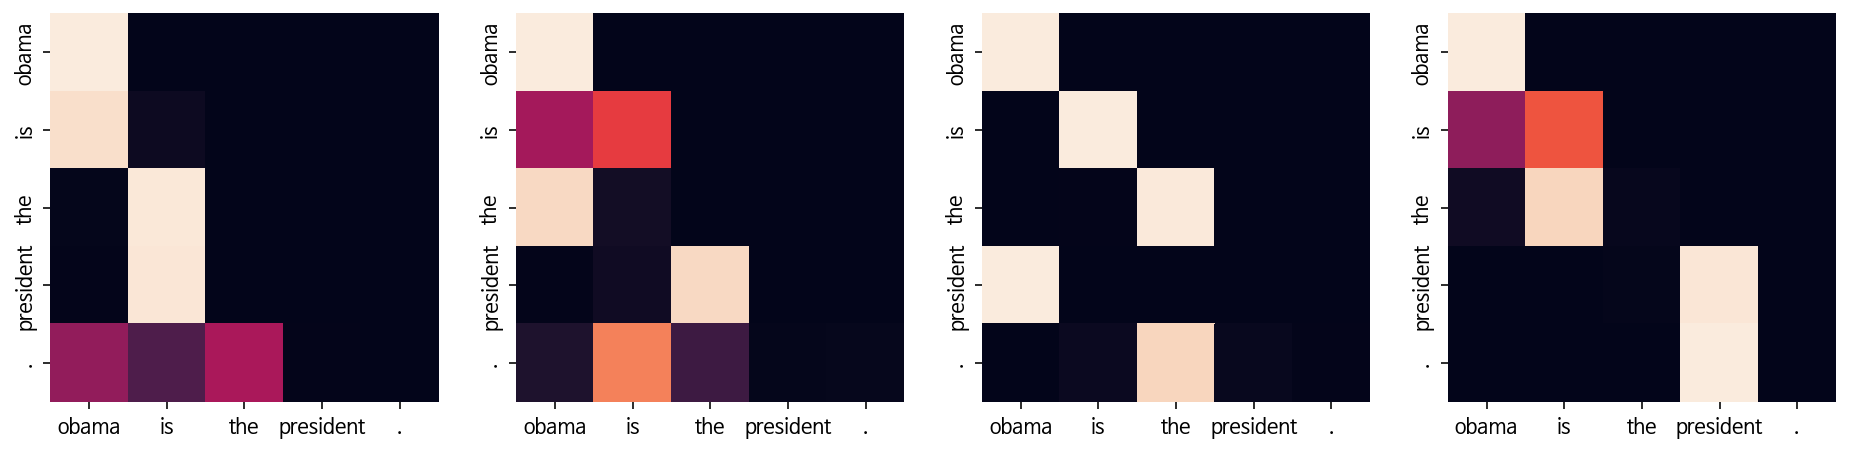


Decoder Src Layer 2


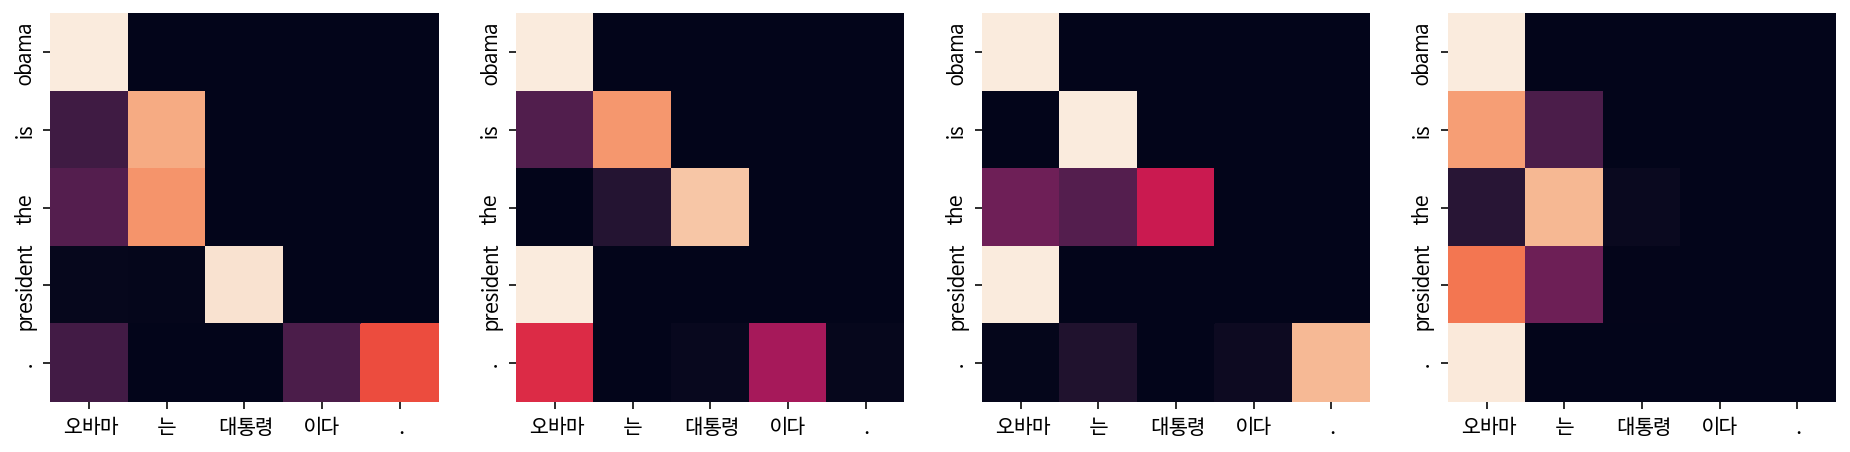

In [ ]:
translate("오바마는 대통령이다.", transformer, ko_tokenizer, en_tokenizer)

Input: 시민들은 도시 속에 산다.
Predicted translation: the city puts around the world .

Encoder Layer 1


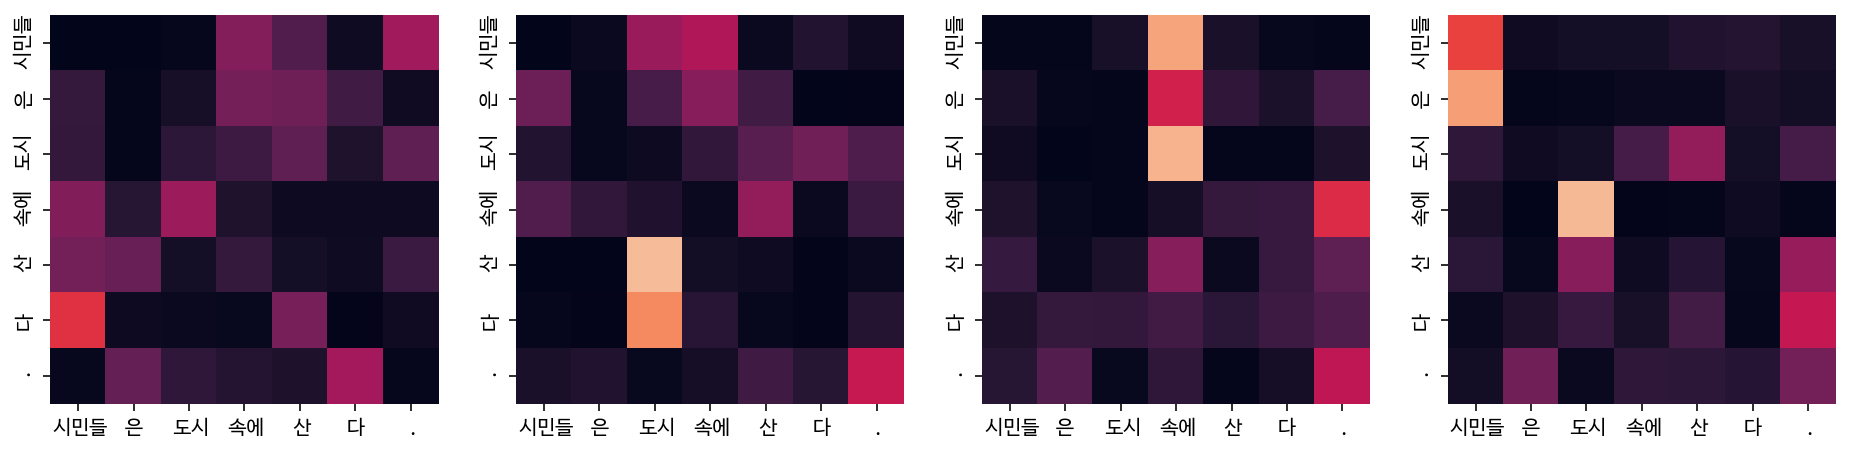


Encoder Layer 2


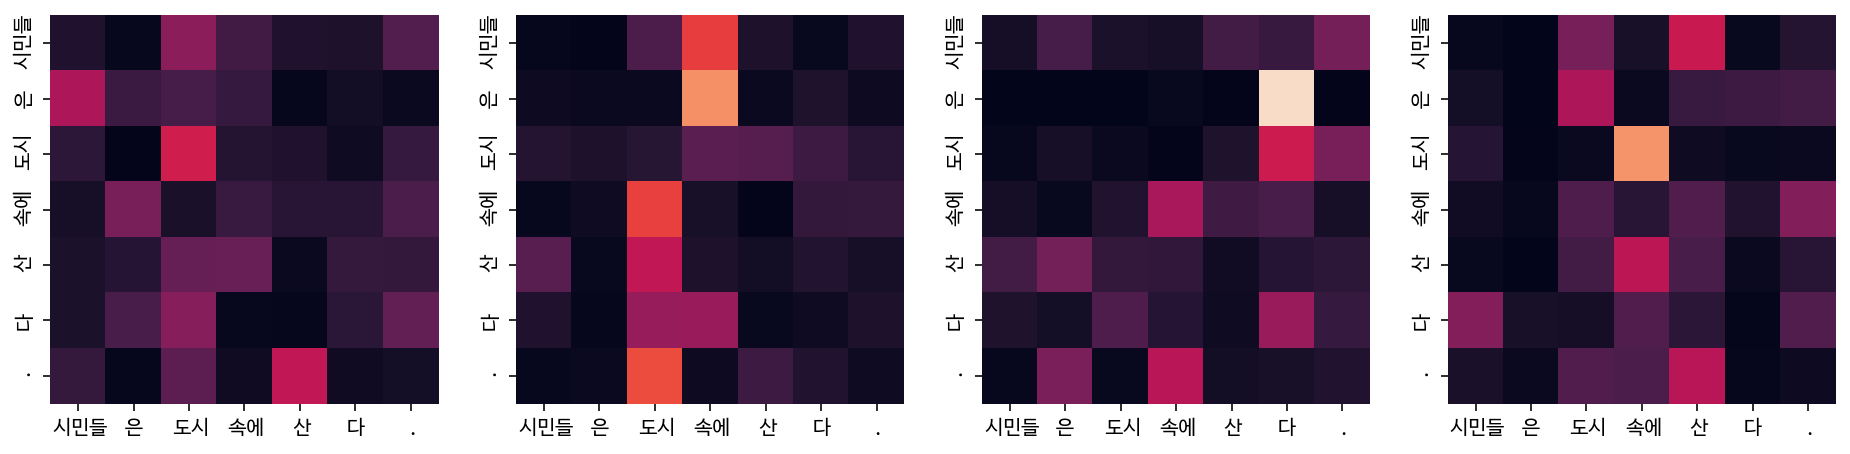


Decoder Self Layer 1


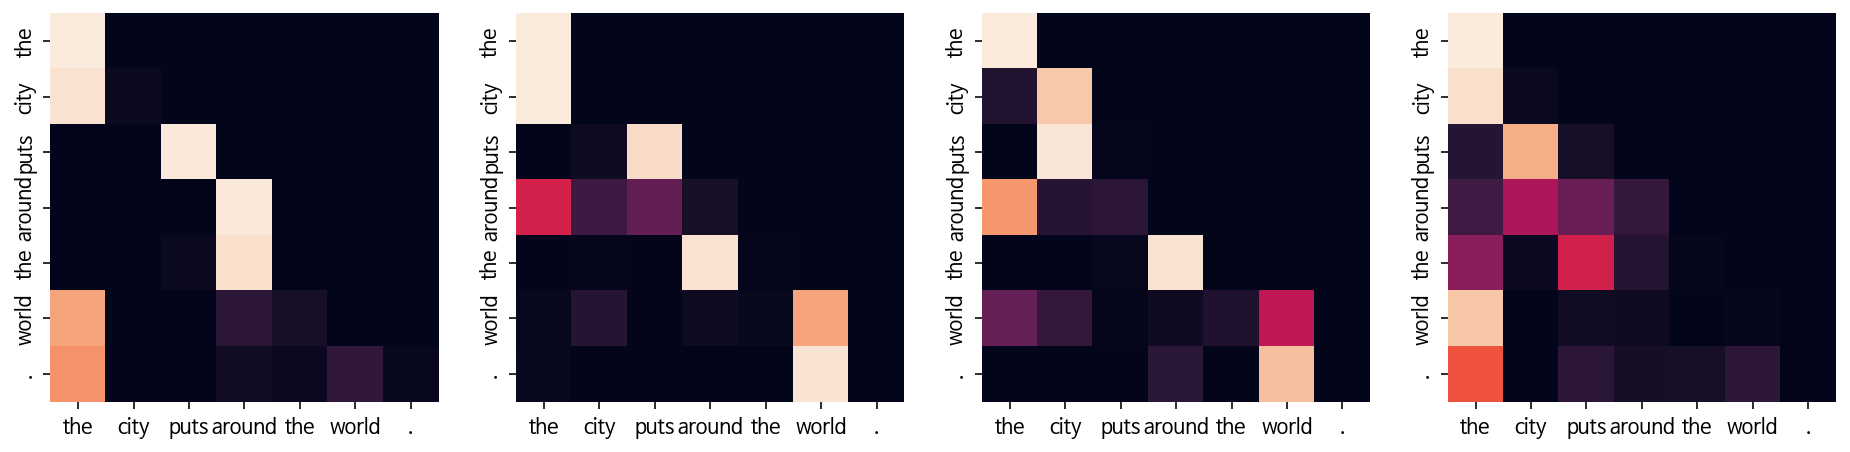


Decoder Src Layer 1


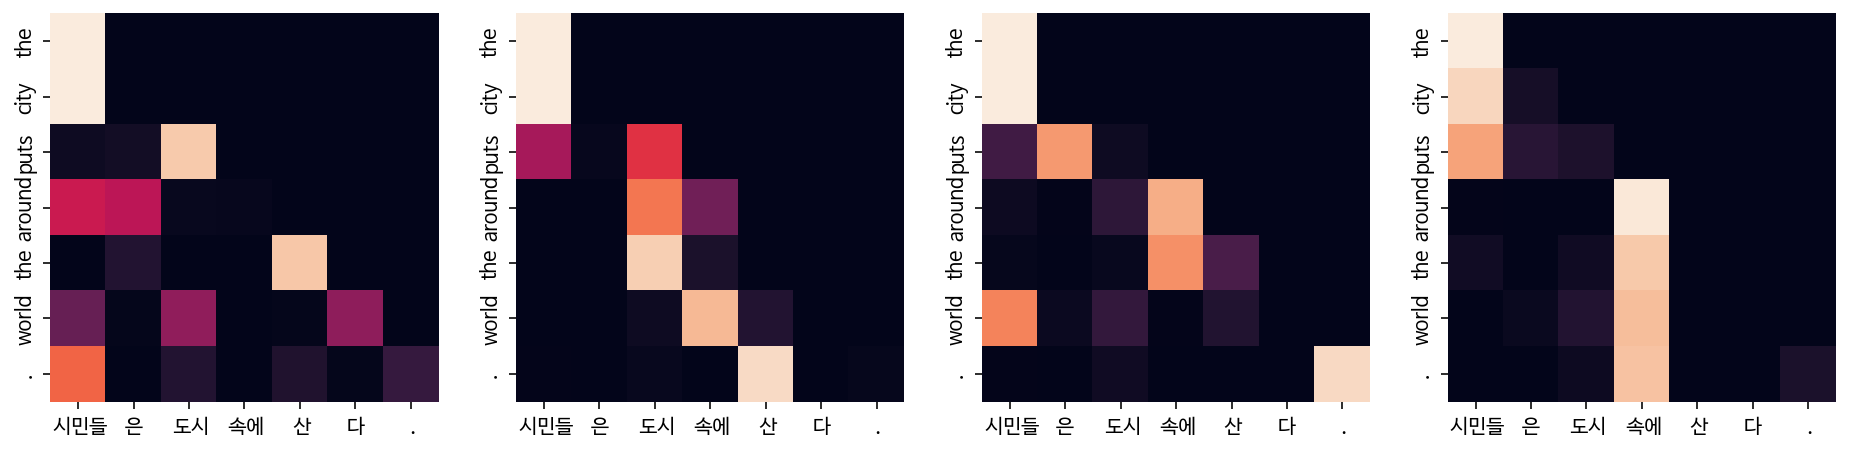


Decoder Self Layer 2


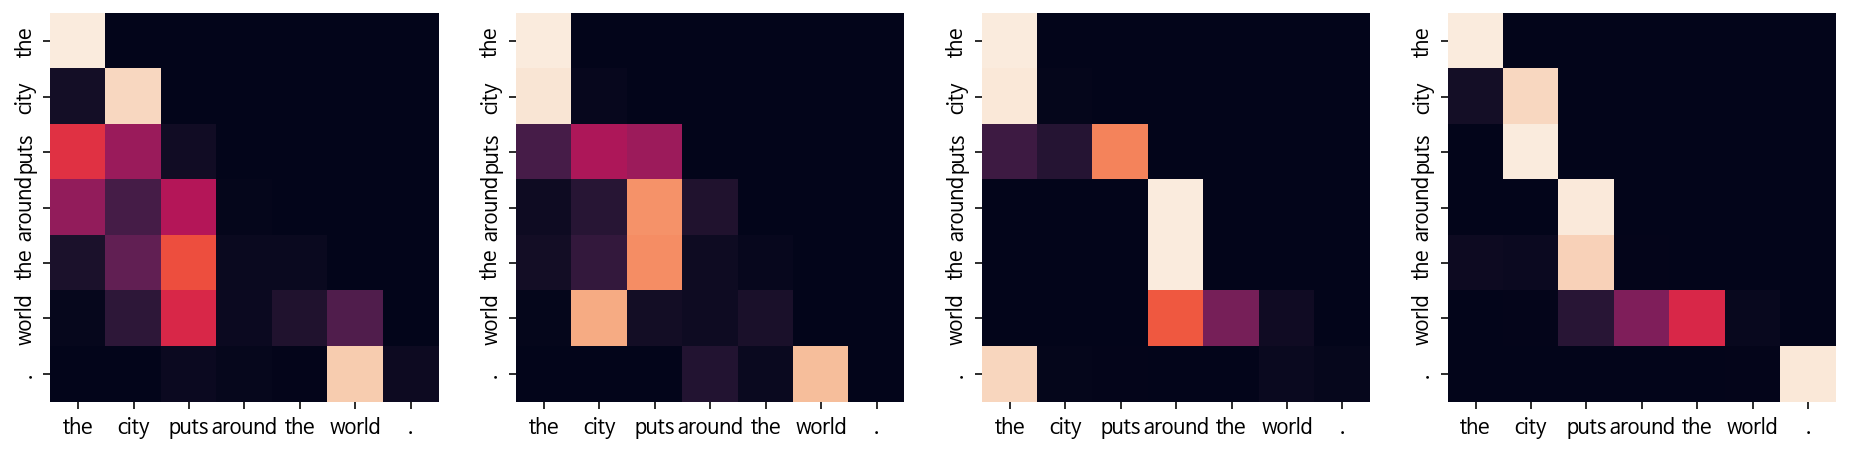


Decoder Src Layer 2


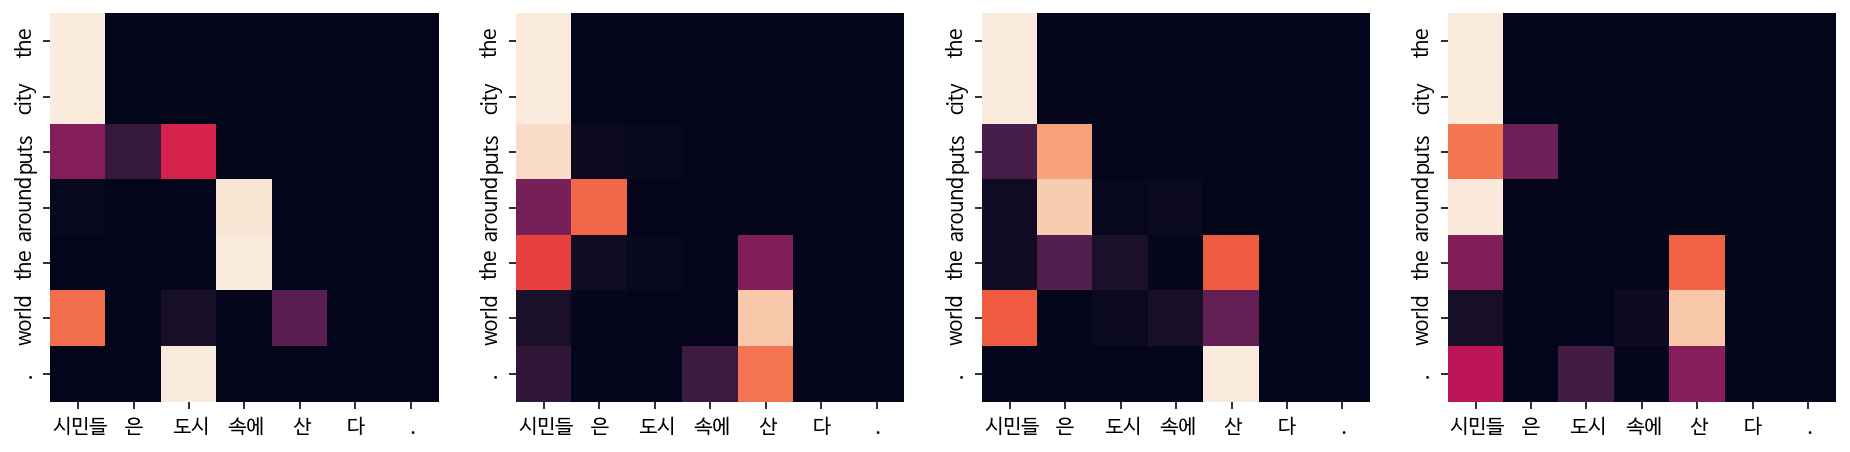

In [ ]:
translate("시민들은 도시 속에 산다.", transformer, ko_tokenizer, en_tokenizer)

Input: 커피는 필요 없다.
Predicted translation: no need to no . . . . no need .

Encoder Layer 1


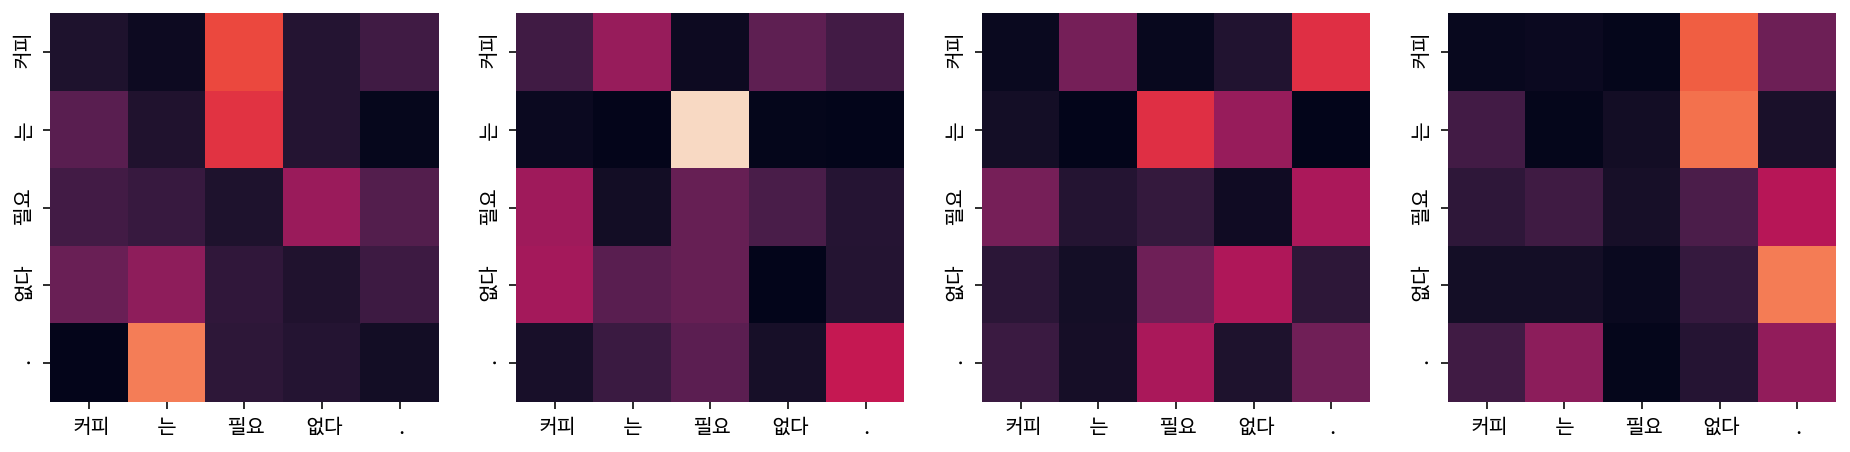


Encoder Layer 2


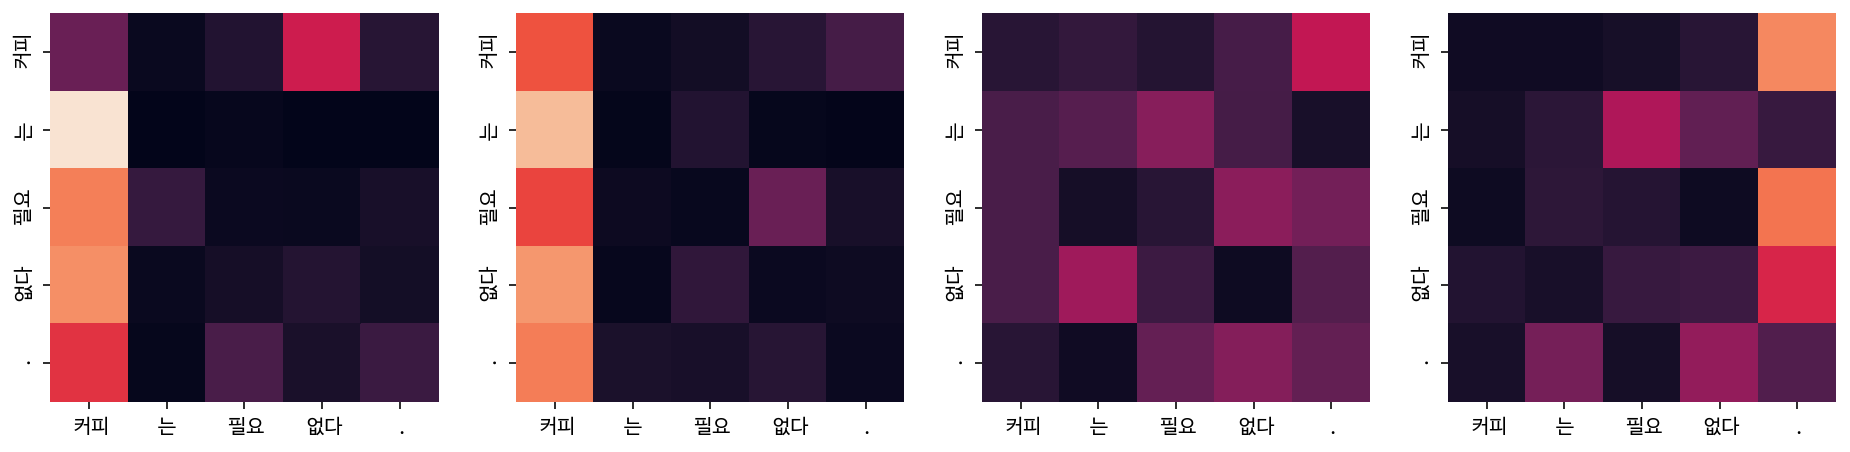


Decoder Self Layer 1


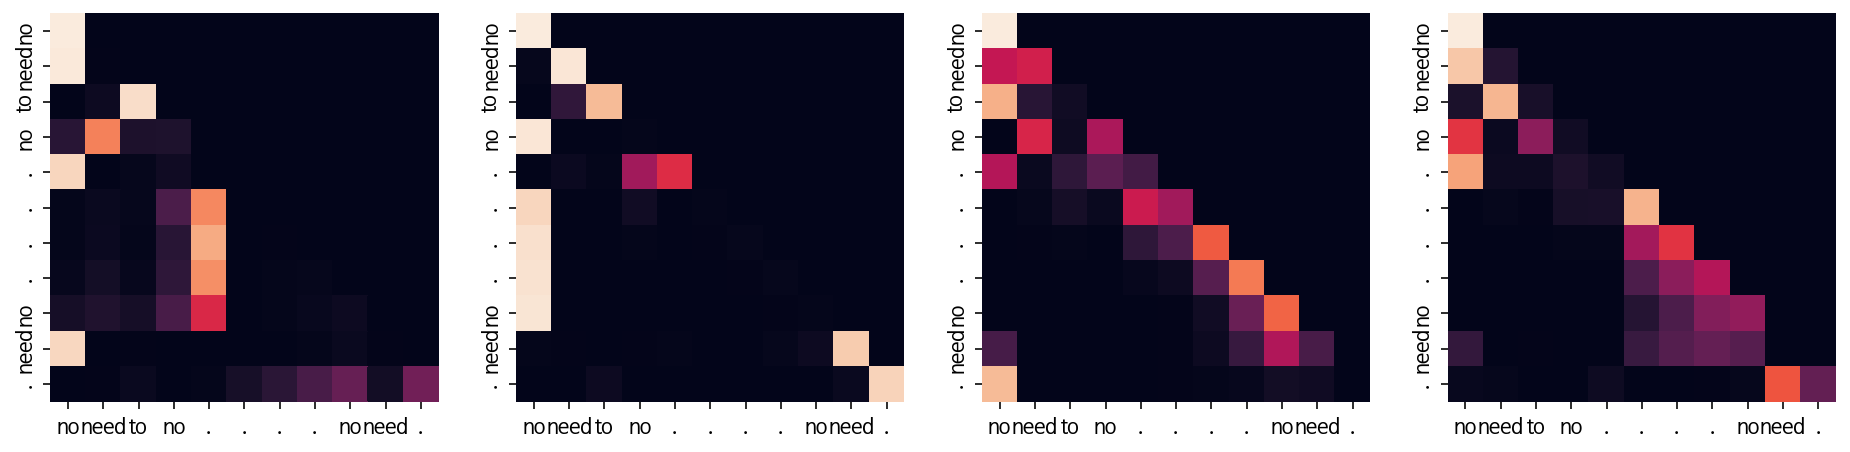


Decoder Src Layer 1


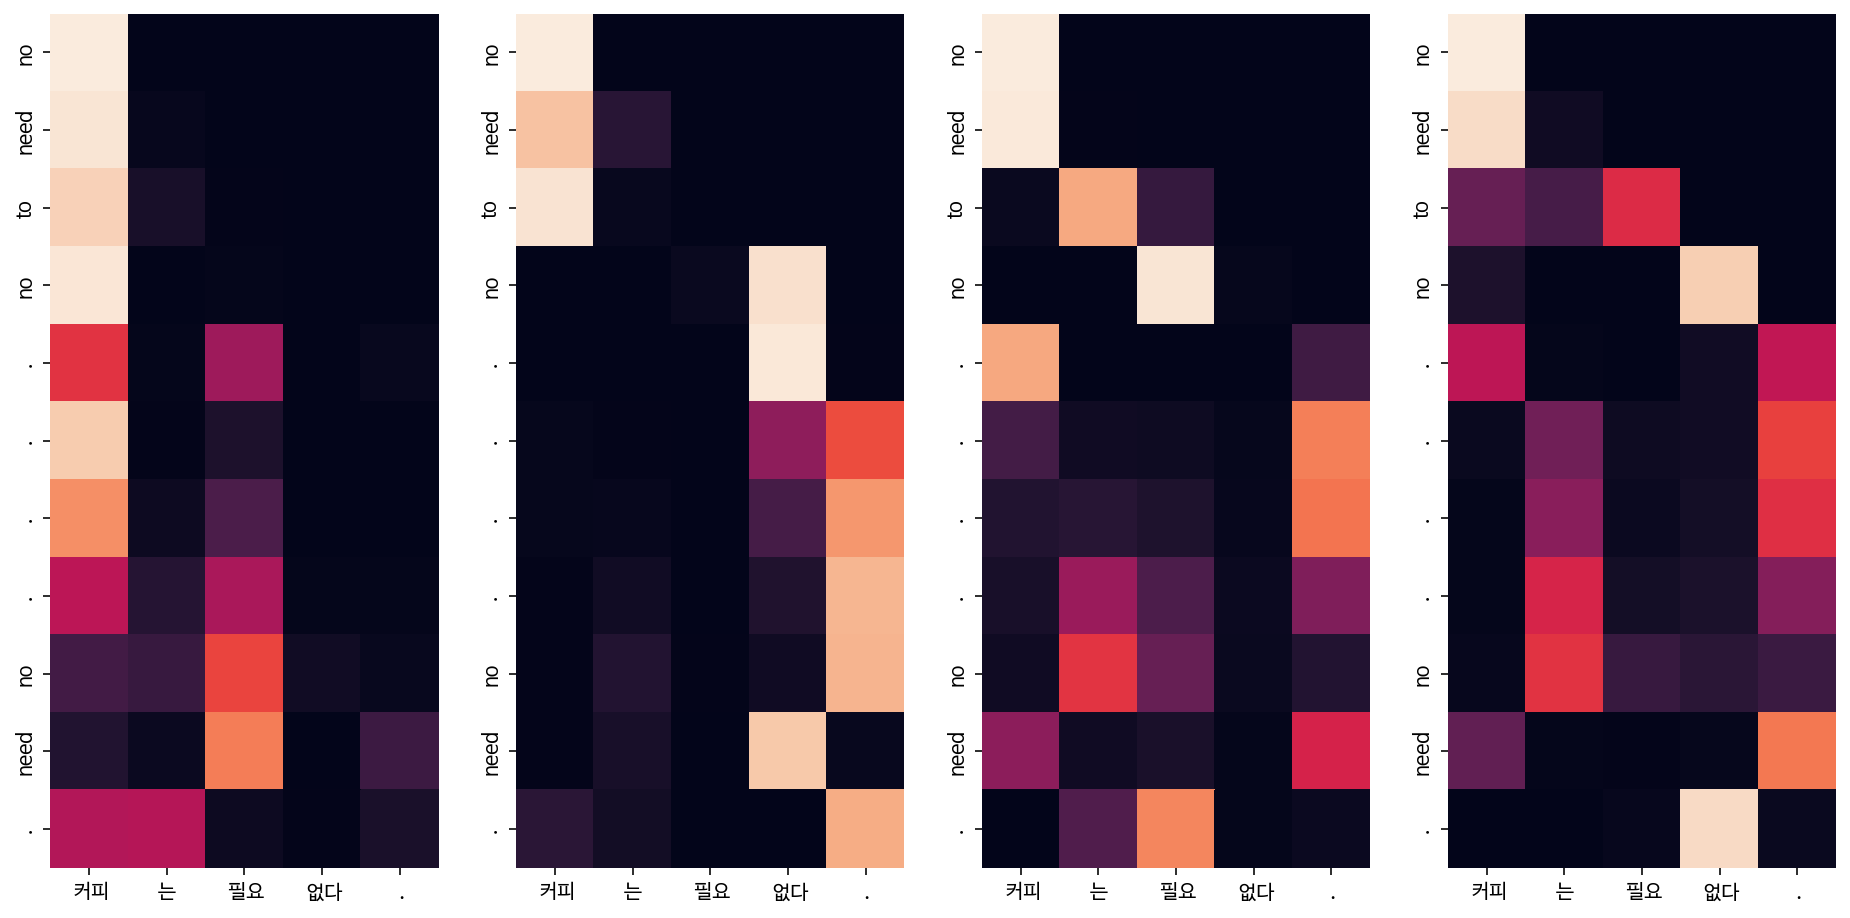


Decoder Self Layer 2


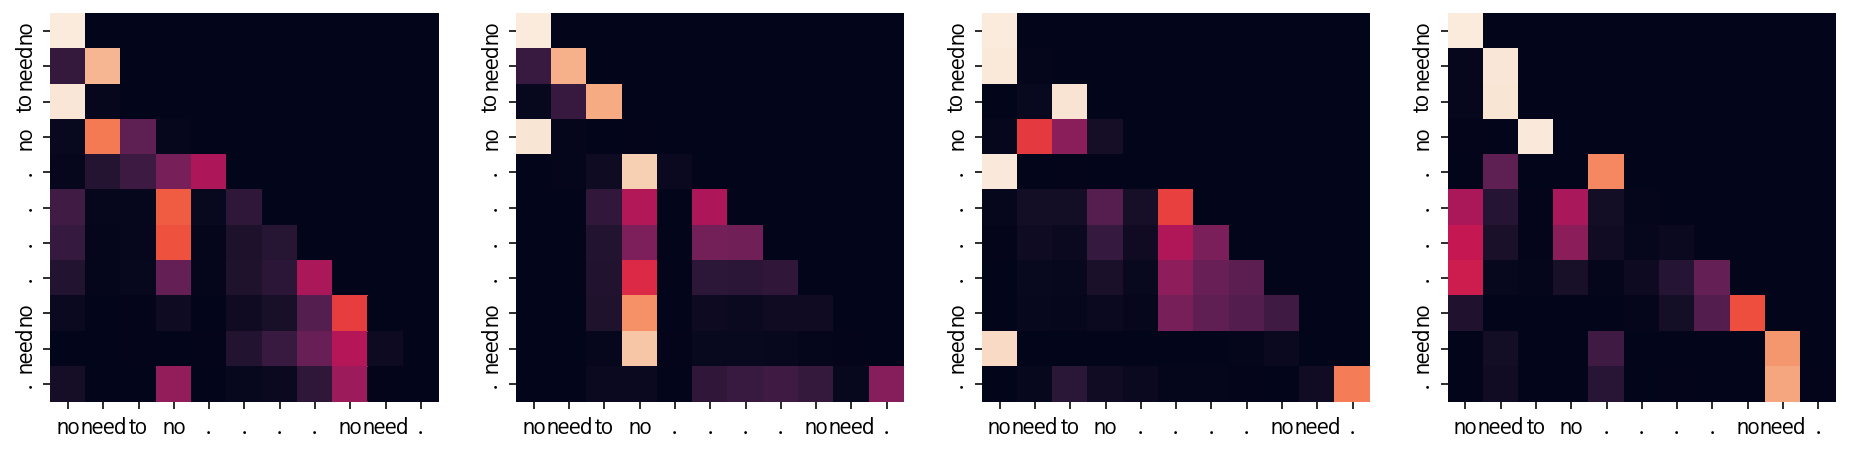


Decoder Src Layer 2


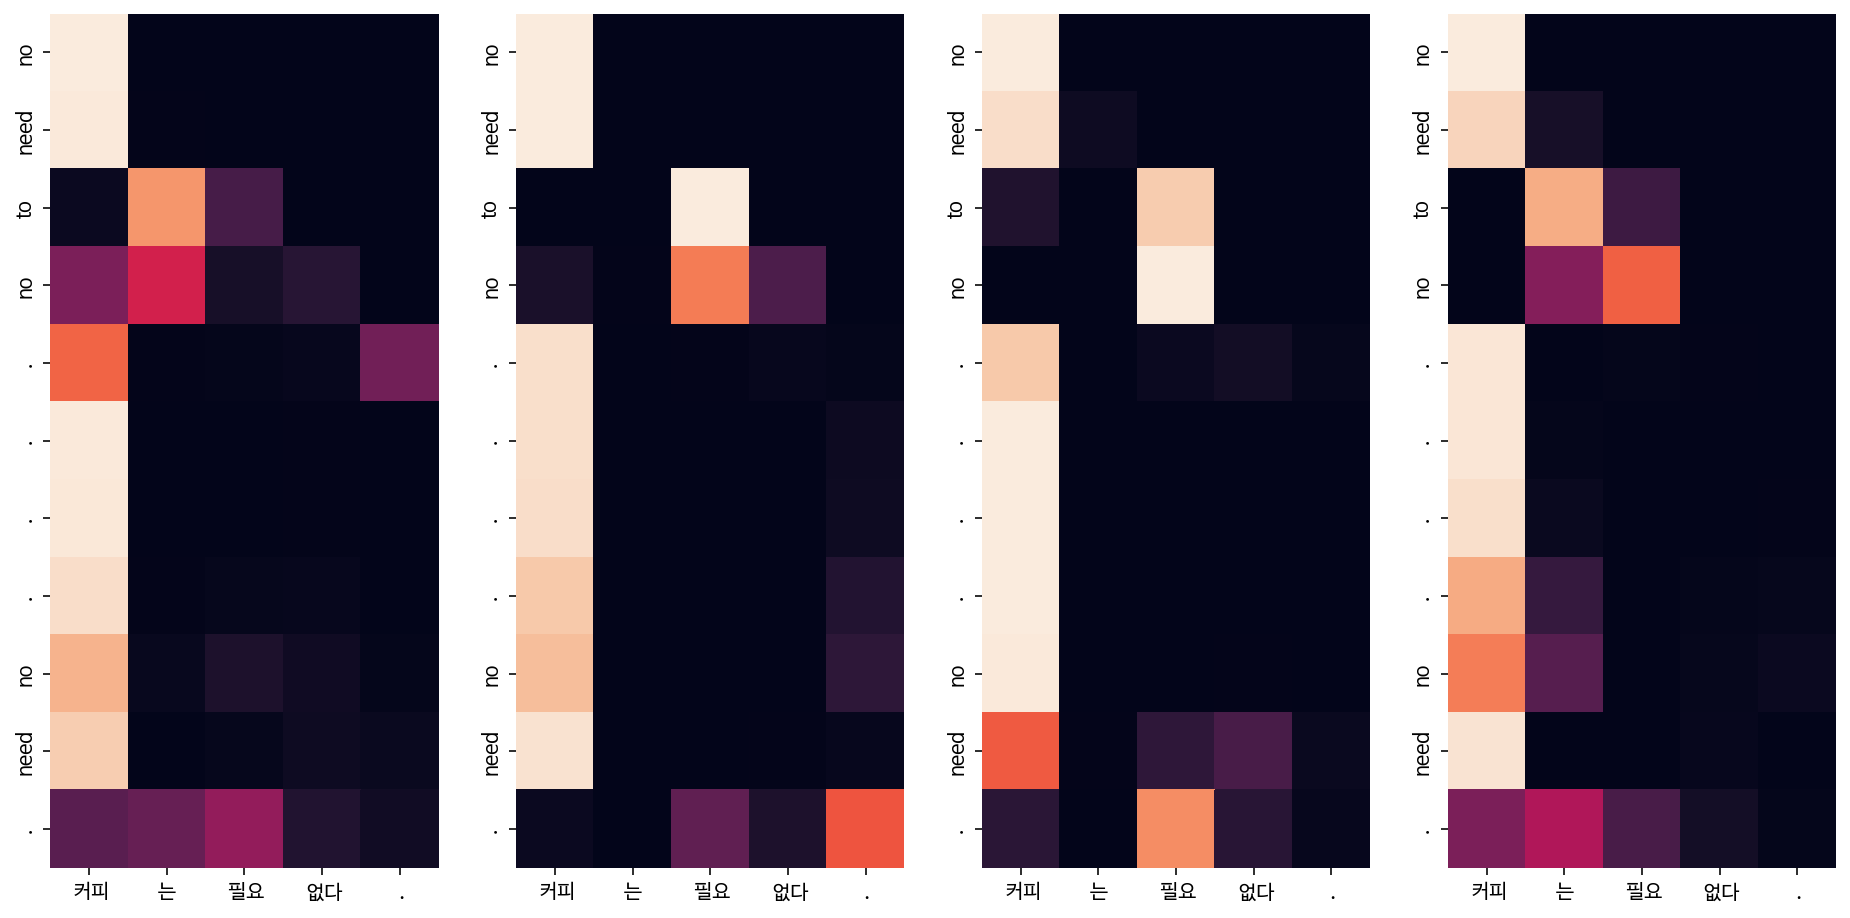

In [ ]:
translate("커피는 필요 없다.", transformer, ko_tokenizer, en_tokenizer)

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven people were killed and seven others were hurt .

Encoder Layer 1


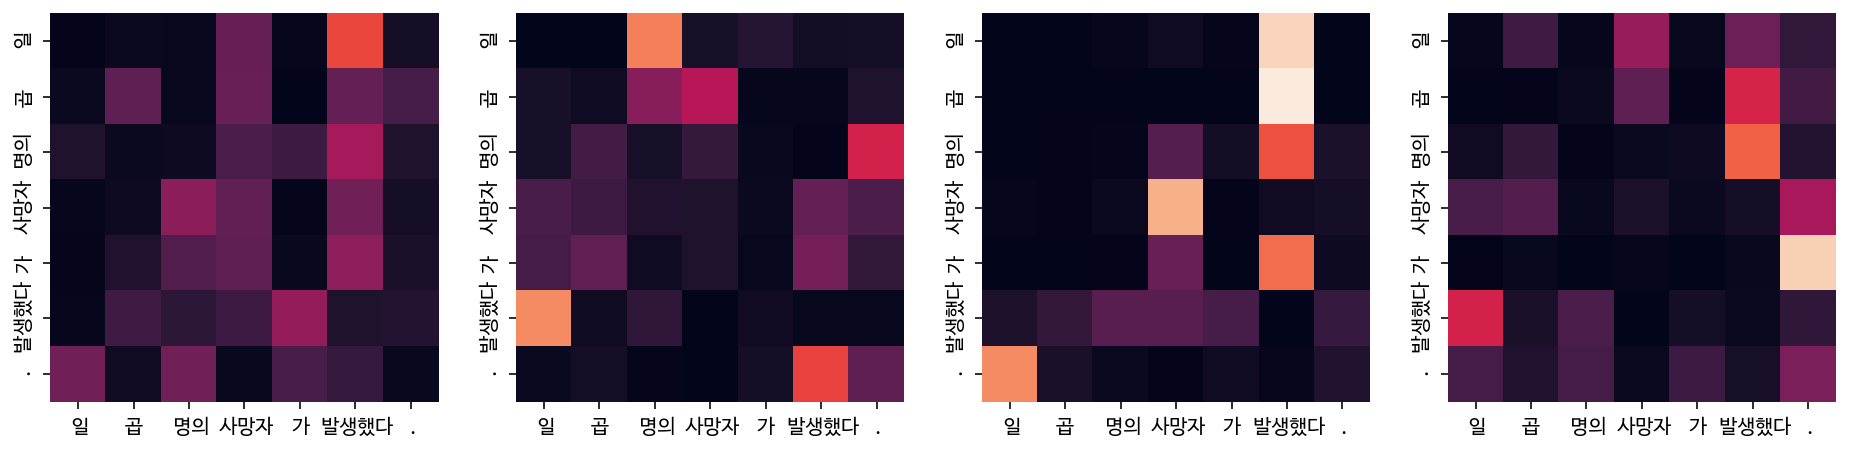


Encoder Layer 2


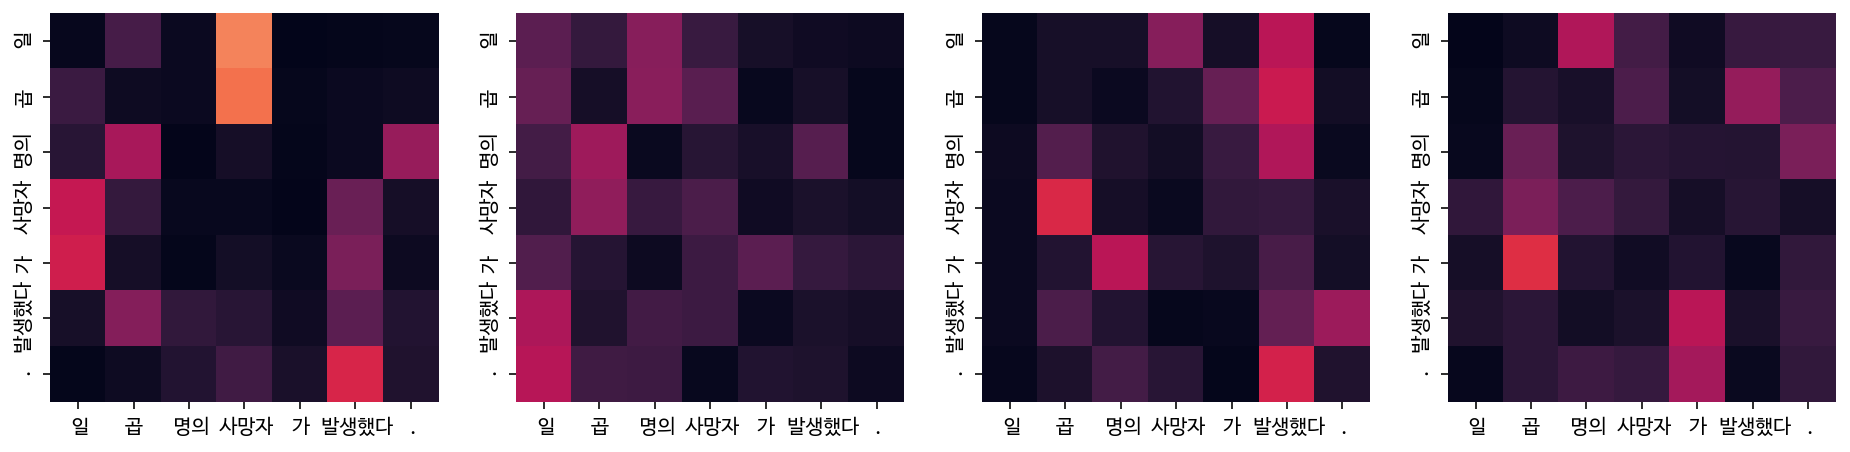


Decoder Self Layer 1


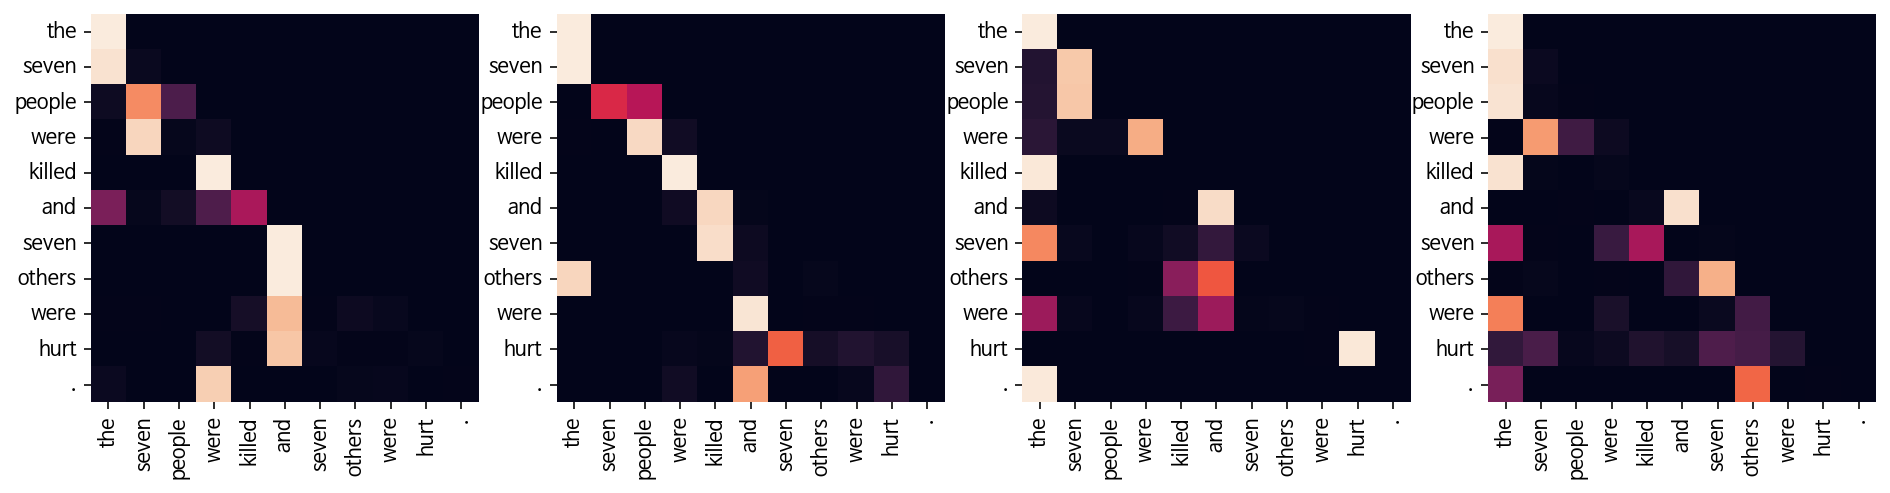


Decoder Src Layer 1


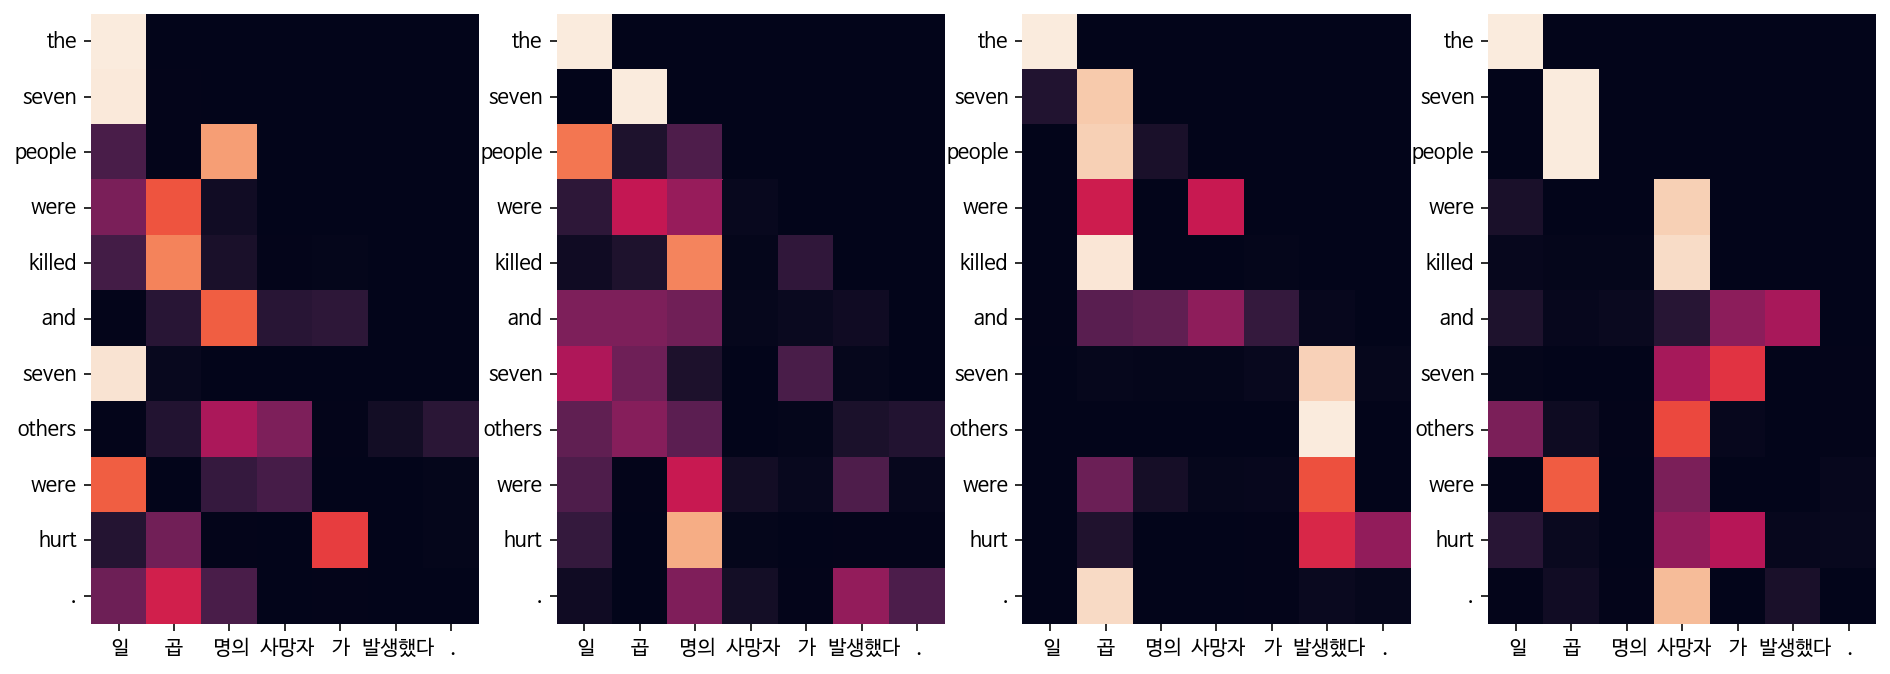


Decoder Self Layer 2


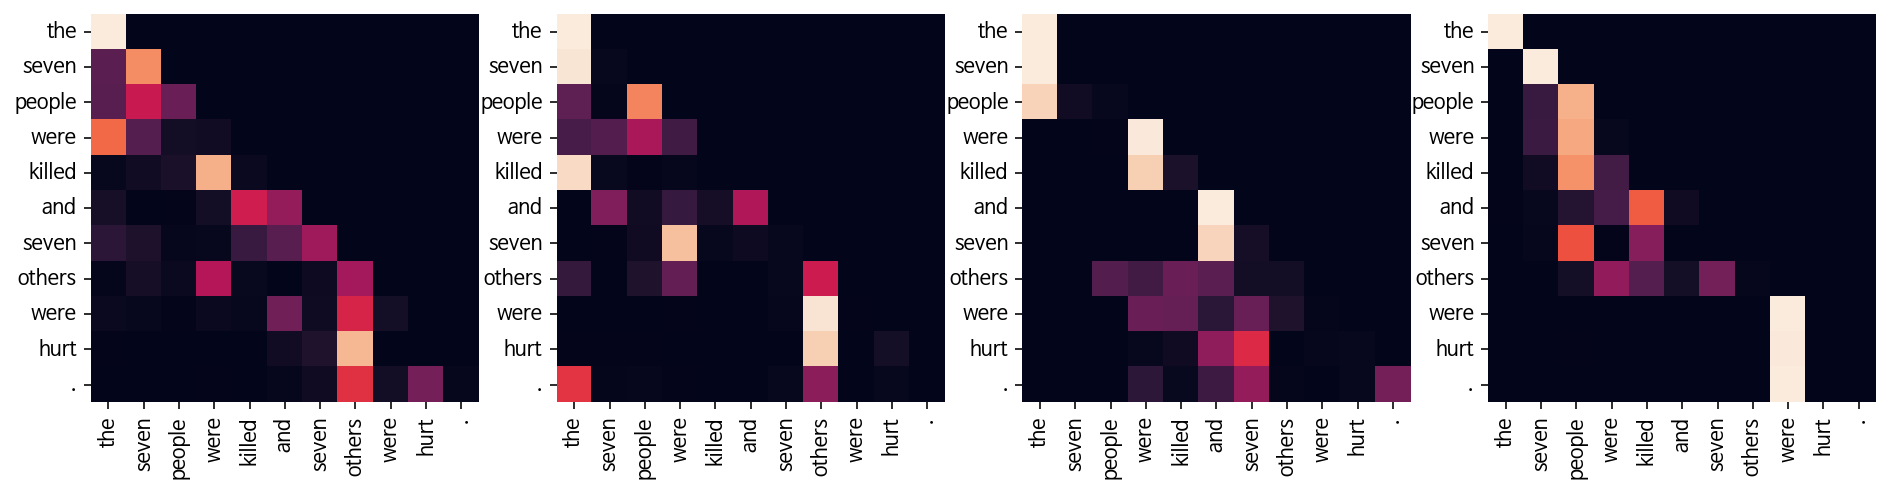


Decoder Src Layer 2


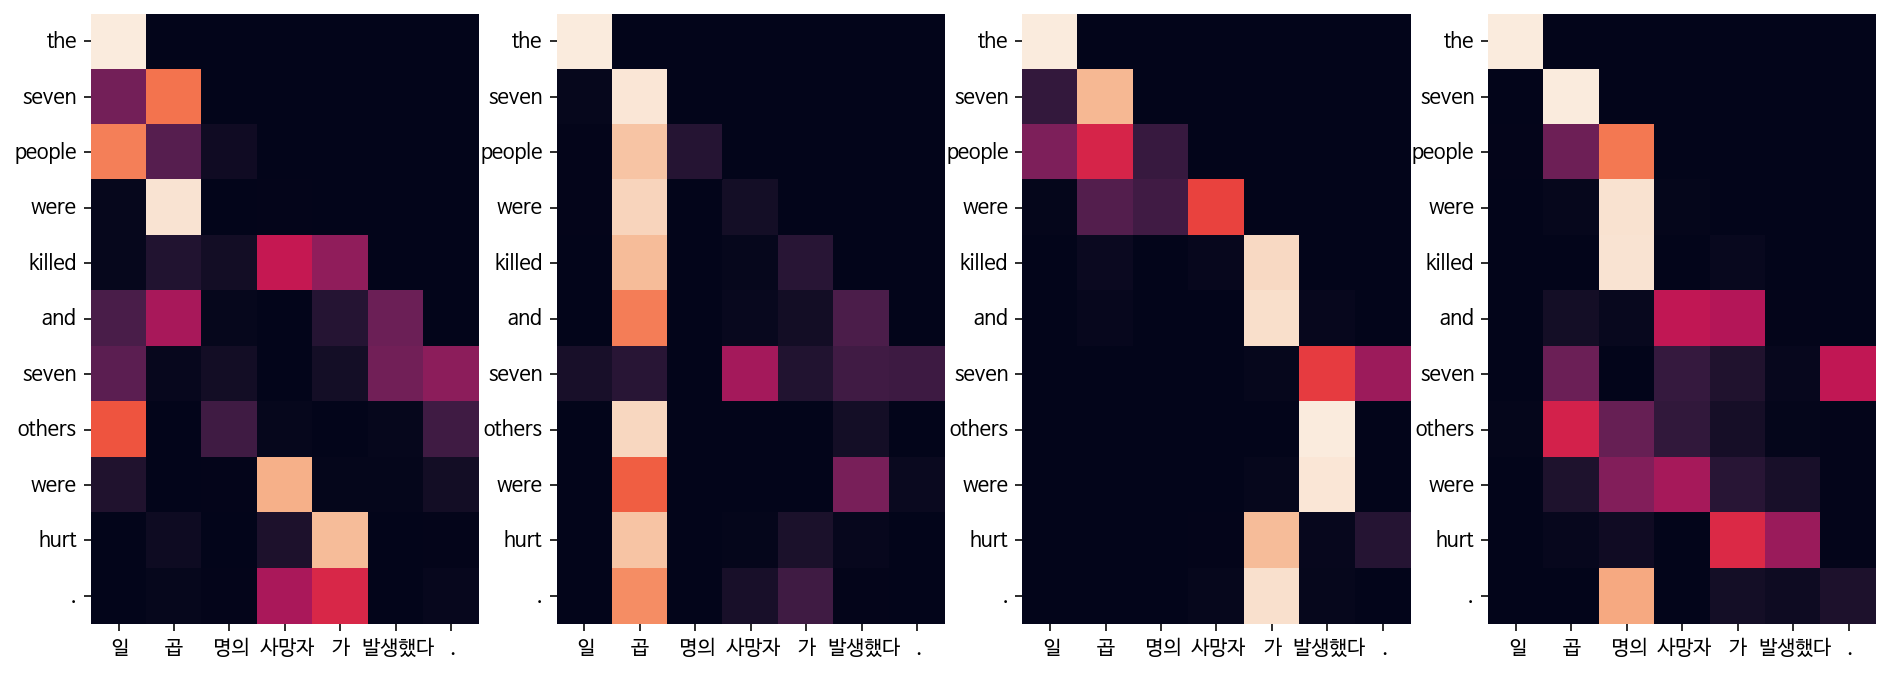

In [ ]:
translate("일곱 명의 사망자가 발생했다.", transformer, ko_tokenizer, en_tokenizer)

#Random State

동일한 하이퍼파라미터와 데이터를 사용했는데 알고리즘을 작동시킬 때마다 다른 모델 학습 결과가 나온다.
<br/>딥러닝 모델은 Random State로 작동하는 것인가?
<br/>그렇다면 Random State로 작동하는 딥러닝 모델의 성능을 어떻게 측정할 수 있는가?
<br/>매번 달라지는 모델 성능을 어떻게 확률분포로 나타낼 수 있는가?

In [ ]:
final_model_loss_df2 = pd.DataFrame({'Epoch':[0],
                             'Train Loss':[0]})

batch_size = 64
epochs = 10
train_count = 0

for epoch in range(epochs):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], batch_size))
    random.shuffle(idx_list)

    for (batch, idx) in enumerate(idx_list):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+batch_size],
                    dec_train[idx:idx+batch_size],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        train_count += 1

        if train_count % len(idx_list) == 0:
            final_model_loss_df2.loc[epoch] = [epoch + 1, round(total_loss.numpy() / (batch + 1), 4)]
            final_model_loss_df2 = final_model_loss_df2.astype({'Epoch':'int'})
            print('Epoch {}  Train Loss {:.4f}'.format(epoch + 1, total_loss.numpy() / (batch + 1)))

Epoch 1  Train Loss 6.0544
Epoch 2  Train Loss 4.5858
Epoch 3  Train Loss 3.9867
Epoch 4  Train Loss 3.5887
Epoch 5  Train Loss 3.1025
Epoch 6  Train Loss 2.4868
Epoch 7  Train Loss 1.9242
Epoch 8  Train Loss 1.4508
Epoch 9  Train Loss 1.0735
Epoch 10  Train Loss 0.8038


In [ ]:
final_model_loss_df2

,Epoch,Train Loss
0,1,6.0544
1,2,4.5858
2,3,3.9867
3,4,3.5887
4,5,3.1025
5,6,2.4868
6,7,1.9242
7,8,1.4508
8,9,1.0735
9,10,0.8038


In [ ]:
final_model_loss_df2.to_csv("/content/drive/MyDrive/lms/transformer_translation/final_model_loss2.csv", index = False)

In [ ]:
sentence_list = ["오바마는 대통령이다.", "시민들은 도시 속에 산다.",
                 "커피는 필요 없다.", "일곱 명의 사망자가 발생했다."]

for sentence in sentence_list:
                    sentence_translator(sentence, transformer, ko_tokenizer, en_tokenizer)
                    print()

Input: 오바마는 대통령이다.
Predicted translation: obama is also a charge for obama .

Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in town part of the city .

Input: 커피는 필요 없다.
Predicted translation: no needed to ask for a coffee .

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: five people were killed in the sunday attack .



#결론

**하이퍼파라미터**

In [ ]:
CSS = """.output {flex-direction: row;}"""
HTML('<style>{}</style>'.format(CSS))

reorderlist = ['Encoder & Decoder Layer', 'Model Dimension', 'Feed Forwad Hidden Layer', 'Feed Forwad Hidden Dimension',
               'Normalization Layer', 'Tokenizer', 'SRC Vocab Size', 'TGT Vocab Size', 'POS Length', 'Text Max Length',
               'Dropout Rate', 'Learning Rate', 'Optimizer', 'Activation Function', 'Loss Function', 'Epoch']
final_hyperparameter = pd.DataFrame({'Final Model':{'Encoder & Decoder Layer':2, 'Model Dimension':512,
                                     'Feed Forwad Hidden Layer':8, 'Feed Forwad Hidden Dimension':2048,
                                     'Normalization Layer':'Pre-LN', 'Tokenizer':'SentencePiece',
                                     'SRC Vocab Size':20000, 'TGT Vocab Size':20000,
                                     'POS Length':256, 'Text Max Length':50, 'Dropout Rate':0.1,
                                     'Learning Rate':'Scheduler', 'Optimizer':'Adam', 'Activation Function':'Relu',
                                     'Loss Function':'Sparse Categorical Crossentropy', 'Epoch':10}})
final_hyperparameter = final_hyperparameter.iloc[pd.Categorical(final_hyperparameter.index,reorderlist).argsort()]

display(final_hyperparameter)
print("\n")
display(final_model_loss_df)

,Final Model
Encoder & Decoder Layer,2
Model Dimension,512
Feed Forwad Hidden Layer,8
Feed Forwad Hidden Dimension,2048
Normalization Layer,Pre-LN
Tokenizer,SentencePiece
SRC Vocab Size,20000
TGT Vocab Size,20000
POS Length,256
Text Max Length,50


,Epoch,Train Loss
0,1,6.0585
1,2,4.5797
2,3,3.9776
3,4,3.5826
4,5,3.0897
5,6,2.4725
6,7,1.9086
7,8,1.4308
8,9,1.0601
9,10,0.7867


**Random State**

동일한 하이퍼파라미터와 데이터를 사용했는데  알고리즘을 작동시킬 때마다 다른 모델 학습 결과가 나온다.
<br/>딥러닝 모델은 Random State로 작동하는 것인가?
<br/>그렇다면 Random State로 작동하는 딥러닝 모델의 성능을 어떻게 측정할 수 있는가?
<br/>매번 달라지는 모델 성능을 어떻게 확률분포로 나타낼 수 있는가?

**모델 초기화**

알고리즘을 다시 작동시킬 때 Google Colab의 런타임을 다시 시작해야 한다.
<br/>런타임 재시작할 때마다 처음부터 코드를 작동시켜야하는 번거로움을 느낀다.
<br/>모델 초기화 함수 코드가 있었다면 런타임을 재시작하지 않아도 되었을 것이다.
<br/>모델 초기화 함수의 필요성을 느낀다.

**Epoch and Overfitting**

Epoch가 늘어날수록 Train Loss값은 떨어지지만
<br/>어느 임계점을 넘어서면 Test Loss가 커지면서 과적합 문제가 발생한다.
<br/>Train Loss과 Test Loss가 수렴을 하다가 그 차이가 벌어지면 과적합 문제가 발생한 것이다.
<br/>따라서 적합한 Epoch에서 학습을 진행하는 것이 바람직하다.

적합한 Epoch는 무엇에 의해 판단되는가?
<br/>그 판단 기준 중의 하나가 데이터의 크기라고 생각한다.
<br/>데이터의 크기가 클수록 Epoch를 크게 잡아도 과적합 문제가 발생할 가능성이 크지 않다고 생각한다.
<br/>데이터의 크기가 크다는 것은 학습 영역의 넓이가 넓다는 것이다.
<br/>그래서 Epoch을 크게 잡아도 Loss값은 계속 떨어지며 지속적인 모델 학습 효과를 낼 수 있을 것이다.

번역기 알고리즘에 쓰인 한국어-영어 병렬 데이터의 크기가 지금보다 몇천배 컸더라면
<br/>Epoch은 2자리수로 충분하지 않을 것이다. 
<br/>3~4자리수로 Epoch을 시도하면서 Loss값의 추이를 확인하는 과정이 필요할 것이다.

최적의 Epoch를 설정하는 기법으로 Early Stopping이 있다.
<br/>Early Stopping은 검증 셋의 손실 값이 최소가 되는 순간 학습을 멈춤으로써 과대 적합을 방지한다. 

#참고문헌

**LMS**
<br/>[dev-sngwn](https://github.com/dev-sngwn)

<br/>**논문**
<br/>[Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin, 「Attention Is All You Need」, NIPS, 2017](https://arxiv.org/pdf/1706.03762.pdf)
<br/>[Ruibin Xiong, Yunchang Yang, Di He, Kai Zheng, Shuxin Zheng, Chen Xing, Huishuai Zhang, Yanyan Lan, Liwei Wang, Tie-Yan Liu, 「On Layer Normalization in the Transformer Architecture」, ICML, 2020](https://arxiv.org/pdf/2002.04745.pdf)

<br/>**단행본**
<br/>유원준 외 1명, 『딥러닝을 이용한 자연어 처리 입문』, Wikidocs, 2022
<br/>[트랜스포머(Transformer)](https://wikidocs.net/31379)
<br/><br/>유원준 외 1명, 『PyTorch로 시작하는 딥러닝 입문』, Wikidocs, 2022
<br/>[선형 회귀(Linear Regression)](https://wikidocs.net/53560)

<br/>**깃허브**
<br/>[Korean English News V1](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)
<br/>[sentencepiece](https://github.com/google/sentencepiece)
<br/>[GD_NLP_5_transformer_translation.ipynb](https://github.com/suheeeee/my_deeplearning_project/blob/main/going_deeper/GD_NLP_5_transformer_translation.ipynb)

<br/>**웹사이트**
<br/>[Sentencepiece를 활용해 Vocab 만들기](https://paul-hyun.github.io/vocab-with-sentencepiece/)
<br/>[자연어처리를 위한 BPE & SentencePiece](http://tensorboy.com/bpe-sentencepiece)
<br/>[ensorflow-3.6 이미지 분류 모델(6)-학습과정확인](https://gooopy.tistory.com/94)
<br/>[Tensorflow-3.7 이미지 분류 모델(7)-조기종료와 콜백](https://gooopy.tistory.com/95?category=876252)
<br/>[매트랩으로 배우는 인공지능 - 7 | Training Option](https://sedangdang.tistory.com/144)

<br/>**공부**
<br/>[tensorflow2.0 series: Eagle execution and Auto Graph](https://programmer.group/tensorflow2.0-series-eagle-execution-and-auto-graph.html)
<br/>[Python 파이썬으로 타이머 만들기 (Feat. Time 모듈)](https://datazzang.tistory.com/6)
<br/>[How to get length of a list of lists in python](https://stackoverflow.com/questions/20151141/how-to-get-length-of-a-list-of-lists-in-python)
<br/>[Removing duplicates from a list of lists](https://stackoverflow.com/questions/2213923/removing-duplicates-from-a-list-of-lists)